First, masks of the fits mosaics.

In [1]:
from os import listdir
from astropy.io import fits
import numpy as np
path = r"/home/eliasw/OneDrive/Research/Deconvolution/fits/miri"
import warnings
warnings.filterwarnings("ignore")

for file in listdir(path): # look through each file
    if file.endswith('.fits.gz'):  # Ensure it's a FITS file
        # Load the weight array
        weight = fits.getdata(path + "/" + file, ext=4)
        # Initialize immask as an array of zeros with the same shape as weight
        immask = np.zeros_like(weight, dtype=int)
        # Set immask to 1 where weight is greater than 0
        immask[weight > 0] = 1
        # Convert immask to an 8-bit integer
        immask_8bit = immask.astype(np.uint8)
        # Open the original FITS file to copy the header from the weight extension
        header = fits.getheader(path + "/" + file, ext=4)  # Assuming ext=4 for weight
        header['EXTNAME'] = "MASK"
        # Create a new FITS PrimaryHDU with immask data and header
        hdu = fits.PrimaryHDU(data=immask_8bit, header=header)
        # Save the new FITS file with the mask data
        output_path = path + "/mask/" + file
        output_path = output_path.replace('.fits.gz','_mask.fits')
        hdu.writeto(output_path, overwrite=True)
        print(f"Mask FITS file saved at {output_path}")

Mask FITS file saved at /home/eliasw/OneDrive/Research/Deconvolution/fits/miri/mask/mosaic_miri_f770w_COSMOS-Web_60mas_A4_v0_5_i2d_mask.fits
Mask FITS file saved at /home/eliasw/OneDrive/Research/Deconvolution/fits/miri/mask/mosaic_miri_f770w_COSMOS-Web_60mas_A5_v0_5_i2d_mask.fits
Mask FITS file saved at /home/eliasw/OneDrive/Research/Deconvolution/fits/miri/mask/mosaic_miri_f770w_COSMOS-Web_60mas_A10_v0_5_i2d_mask.fits
Mask FITS file saved at /home/eliasw/OneDrive/Research/Deconvolution/fits/miri/mask/mosaic_miri_f770w_COSMOS-Web_60mas_A1_v0_5_i2d_mask.fits
Mask FITS file saved at /home/eliasw/OneDrive/Research/Deconvolution/fits/miri/mask/mosaic_miri_f770w_COSMOS-Web_60mas_A3_v0_5_i2d_mask.fits
Mask FITS file saved at /home/eliasw/OneDrive/Research/Deconvolution/fits/miri/mask/mosaic_miri_f770w_COSMOS-Web_60mas_A2_v0_5_i2d_mask.fits
Mask FITS file saved at /home/eliasw/OneDrive/Research/Deconvolution/fits/miri/mask/mosaic_miri_f770w_COSMOS-Web_60mas_A8_v0_5_i2d_mask.fits
Mask FITS fi

Now let's use these masks to find galaxies from the COSMOS+2020 catalog. We are also going to add checks for galaxies with
* $2<R_{50}<6.4$ pix
* $24.5<\textrm{Mag}<25.5$ in Y, H, and Ks bands.
* S/N $> 3$ in Y, H, Ks bands. \
To accomplish this, we need to add additional parameters from the COSMOS+2020 catalog.

In [59]:
import pandas as pd

# Define the path to the FITS files
path = r"/home/eliasw/OneDrive/Research/Deconvolution/fits"

# Load the galaxy data and FITS file ranges
obj = pd.read_csv('input/COSMOSPHOT.csv', sep=',', header=0)

After merging the Classic (for the ID, RA, DEC, 50% flux radius, and redshift) and the Farmer (for the photometrics) catalogs from the COSMOS+2020 catalog, we can now start updating the cut criteria for our imaging tool.

In [60]:
obj

,Classic,DEJ2000,EZzphot,lpzBEST,RAJ2000,radFlux,UVISTAYmag,UVISTAHmag,FUVISTAKs,e_FUVISTAKs,UVISTAKsmag,e_UVISTAKsmag,FUVISTAY,e_FUVISTAY,e_UVISTAYmag,FUVISTAH,e_UVISTAHmag,e_FUVISTAH
0,275886,1.677451,0.573705,NaN,149.809627,4.42,21.5977,21.3176,14.41,0.035428,21.0033,0.002669,8.34,0.015957,0.002079,10.79,0.002348,0.023336
1,275134,1.680061,0.787219,0.7352,149.888246,4.02,23.8737,23.7232,1.77,0.053852,23.2788,0.032996,1.02,0.066159,0.070111,1.18,0.090931,0.098561
2,272305,1.677908,1.399695,1.3698,149.879218,4.77,23.8501,23.7618,1.28,0.051221,23.6352,0.043577,1.05,0.052477,0.054415,1.14,0.074841,0.078288
3,271753,1.678074,1.246581,1.5063,149.876875,3.34,NaN,26.4426,0.28,0.035810,25.2697,0.137273,-0.01,0.031748,NaN,0.10,0.529906,0.046928
4,274033,1.680335,0.412991,1.7611,149.881965,8.36,NaN,25.1853,0.04,0.038734,27.3067,0.969397,-0.02,0.047389,NaN,0.31,0.248853,0.070160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236448,994776,2.360402,2.055357,2.3198,149.798346,4.58,23.4797,22.7098,3.29,0.027753,22.6059,0.009149,1.47,0.013237,0.009759,2.99,0.007329,0.020201
236449,996015,2.362869,2.989083,2.8236,149.800852,4.09,26.2089,26.6471,0.11,0.024174,26.2804,0.235096,0.12,0.011451,0.104260,0.08,0.238859,0.017522
236450,998266,2.364107,10.629337,7.3993,149.802372,NaN,26.0901,NaN,0.10,0.019899,26.4400,0.224152,0.13,0.009942,0.081138,-0.08,NaN,0.014630
236451,998586,2.365249,4.870573,4.0625,149.802850,0.95,27.3039,26.2378,0.15,0.018123,25.9438,0.129263,0.04,0.008727,0.217848,0.12,0.122864,0.013140


In [61]:
(obj['FUVISTAH']/obj['e_FUVISTAH'])

0         462.371766
1          11.972293
2          14.561674
3           2.130929
4           4.418447
             ...    
236448    148.011009
236449      4.565663
236450     -5.468066
236451      9.132698
236452    341.800147
Length: 236453, dtype: float64

Here we have SNR's for the H band. Let's calculate these for all 3 bands, and then update our mini-catalog with them for easier recollection.

In [62]:
obj['SNR_FUVISTAH']=(obj['FUVISTAH']/obj['e_FUVISTAH'])
obj['SNR_FUVISTAY']=(obj['FUVISTAY']/obj['e_FUVISTAY'])
obj['SNR_FUVISTAKs']=(obj['FUVISTAKs']/obj['e_FUVISTAKs'])

In [63]:
obj

,Classic,DEJ2000,EZzphot,lpzBEST,RAJ2000,radFlux,UVISTAYmag,UVISTAHmag,FUVISTAKs,e_FUVISTAKs,...,e_UVISTAKsmag,FUVISTAY,e_FUVISTAY,e_UVISTAYmag,FUVISTAH,e_UVISTAHmag,e_FUVISTAH,SNR_FUVISTAH,SNR_FUVISTAY,SNR_FUVISTAKs
0,275886,1.677451,0.573705,NaN,149.809627,4.42,21.5977,21.3176,14.41,0.035428,...,0.002669,8.34,0.015957,0.002079,10.79,0.002348,0.023336,462.371766,522.654634,406.741579
1,275134,1.680061,0.787219,0.7352,149.888246,4.02,23.8737,23.7232,1.77,0.053852,...,0.032996,1.02,0.066159,0.070111,1.18,0.090931,0.098561,11.972293,15.417404,32.867738
2,272305,1.677908,1.399695,1.3698,149.879218,4.77,23.8501,23.7618,1.28,0.051221,...,0.043577,1.05,0.052477,0.054415,1.14,0.074841,0.078288,14.561674,20.008918,24.989702
3,271753,1.678074,1.246581,1.5063,149.876875,3.34,NaN,26.4426,0.28,0.035810,...,0.137273,-0.01,0.031748,NaN,0.10,0.529906,0.046928,2.130929,-0.314977,7.819154
4,274033,1.680335,0.412991,1.7611,149.881965,8.36,NaN,25.1853,0.04,0.038734,...,0.969397,-0.02,0.047389,NaN,0.31,0.248853,0.070160,4.418447,-0.422037,1.032682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236448,994776,2.360402,2.055357,2.3198,149.798346,4.58,23.4797,22.7098,3.29,0.027753,...,0.009149,1.47,0.013237,0.009759,2.99,0.007329,0.020201,148.011009,111.048998,118.545316
236449,996015,2.362869,2.989083,2.8236,149.800852,4.09,26.2089,26.6471,0.11,0.024174,...,0.235096,0.12,0.011451,0.104260,0.08,0.238859,0.017522,4.565663,10.479434,4.550381
236450,998266,2.364107,10.629337,7.3993,149.802372,NaN,26.0901,NaN,0.10,0.019899,...,0.224152,0.13,0.009942,0.081138,-0.08,NaN,0.014630,-5.468066,13.076313,5.025403
236451,998586,2.365249,4.870573,4.0625,149.802850,0.95,27.3039,26.2378,0.15,0.018123,...,0.129263,0.04,0.008727,0.217848,0.12,0.122864,0.013140,9.132698,4.583345,8.276730


Let's check our critera, and see how many sources (out of 236,453), meet the critera of having all SNR > 3.

In [64]:
((obj['SNR_FUVISTAH'] > 3) & (obj['SNR_FUVISTAKs'] > 3) & (obj['SNR_FUVISTAY'] > 3)).sum()

163640

163,640 galaxies out of 236,453 have high enough S/N ratios for our use.

In [65]:
obj.to_csv('input/COSMOSPHOT_SNR.csv',index=False) # saving our new data frame

# Main Work

In [2]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from os import listdir
import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore")

# Define the path to the FITS files
path = r"/home/eliasw/OneDrive/Research/Deconvolution/fits"

# Load the galaxy data and FITS file ranges
obj = pd.read_csv('input/COSMOSPHOT_SNR.csv', sep=',', header=0)
ranges = pd.read_csv('fits/sectionrange.txt', sep='\t', header=0)

In [3]:
ranges

,Section,RAmin,RAmax,DECmin,DECmax
0,A1,149.719880,149.941350,2.085651,2.335409
1,A2,149.855451,150.076930,2.036359,2.286127
2,A3,149.991016,150.212502,1.987055,2.236831
3,A4,150.126573,150.348064,1.937741,2.187521
4,A5,150.262121,150.483614,1.888417,2.138200
5,A6,149.654075,149.875509,1.904809,2.154561
6,A7,149.789629,150.011074,1.855522,2.105283
7,A8,149.925179,150.146632,1.806224,2.055991
8,A9,150.060721,150.282180,1.756917,2.006688
9,A10,150.196256,150.417717,1.707601,1.957374


In [ ]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from os import listdir
import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore")

# Define the path to the FITS files
path = r"/home/eliasw/OneDrive/Research/Deconvolution/fits"

# Load the galaxy data and FITS file ranges
obj = pd.read_csv('input/withinrangeCOSMOS2020.csv', sep=',', header=0)
ranges = pd.read_csv('input/fitsrange.txt', sep='\t', header=0)

# Preload FITS headers and data
def preload_fits_files(path):
    fits_data = {}
    for file in listdir(path):
        if file.endswith('.fits.gz'):  # Ensure it's a FITS file
            header = WCS(fits.getheader(path + '/' + file, ext=1), fix=False)  # Get WCS header for pixel to RA/Dec conversion
            mask = fits.getdata((path + '/mask/' + file).replace('.fits.gz','_mask.fits'))  # Load only the necessary data extension
            fits_data[file] = {'wcs': header, 'mask': mask}
    return fits_data

# Function to search for galaxies in preloaded FITS files for a subset of galaxies
def search_galaxies(start_index, end_index, fits_data):
    foundgals = 0
    found_objects = []
        
    end_index = min(end_index, len(obj)) #indexing fix
    #print(f"Processing indices from {start_index} to {end_index}")

    for i in range(start_index, end_index):
       # print(f"Checking index {i}, Galaxy ID {obj['Classic'][i]}") 
        for file, file_data in fits_data.items():  # Loop through preloaded FITS data
            ramin = float(ranges[ranges['File'] == file]['RAmin'])
            ramax = float(ranges[ranges['File'] == file]['RAmax'])
            decmin = float(ranges[ranges['File'] == file]['DECmin'])
            decmax = float(ranges[ranges['File'] == file]['DECmax'])
            # Check if the galaxy is within the RA/Dec range of the file
            if ramin <= obj['RAJ2000'][i]:
                if obj['RAJ2000'][i] <= ramax:
                    if decmin <= obj['DEJ2000'][i]:
                        if obj['DEJ2000'][i] <= decmax:
                            w = file_data['wcs']  # Get the preloaded WCS header
                            xpix, ypix = w.all_world2pix(obj['RAJ2000'][i], obj['DEJ2000'][i], 1)
                            # Check if the pixel coordinates are within bounds
                            if (0 <= xpix <= 9600 and 0 <= ypix <= 12455):
                                if (file_data['mask'][int(ypix),int(xpix)] == True):  # if data at position in mask
                                    if ((obj['SNR_FUVISTAH'] > 3) & (obj['SNR_FUVISTAKs'] > 3) & (obj['SNR_FUVISTAY'] > 3))==True: # if the SNR is > 3 pass
                                        if (6.4 > (obj['radFlux']*(15/3600)*(fits_data['wcs']['CDELT1'])) > 2) == True: #if the radius that 50% of the flux is within is between 2 and 6.4 pixels, pass
                                            if (((obj['UVISTAHmag'] > 25.5) & (obj['UVISTAHmag'] > 24.5)) & ((obj['UVISTAYmag'] > 25.5) & (obj['UVISTAYmag'] > 24.5)) & ((obj['UVISTAKsmag'] > 25.5) & (obj['UVISTAKsmag'] > 24.5))) == True: # if mag of all bands is 24.5<x<25.5, pass
                                                foundgals += 1
                                                #print(f"Galaxy found at index {i}, ID {obj['Classic'][i]} in file {file}, at coords {obj['RAJ2000'][i]} RA and {obj['DEJ2000'][i]} DEC")
                                                found_objects.append([obj['Classic'][i], obj['RAJ2000'][i], obj['DEJ2000'][i], file])  # Save RA, Dec, and file
                                                break  # Stop searching this file if galaxy found
            
    return foundgals, found_objects

# Multi-core processing: split the galaxy list into chunks
if __name__ == '__main__':
    num_cores = mp.cpu_count()  # Use all available cores
    chunk_size = len(obj) // num_cores  # Determine the size of each chunk

    # Preload all FITS files and headers before starting the search
    fits_data = preload_fits_files(path)

    # Create a pool of workers and distribute the work
    with mp.Pool(num_cores) as pool:
        results = [pool.apply_async(search_galaxies, args=(i, i + chunk_size, fits_data)) for i in range(0, len(obj), chunk_size)]
        
        found_gals = 0
        found_objects = []

        for result in results:
            chunk_found_gals, chunk_found_details = result.get()  # Get both elements from the result tuple
            found_gals += chunk_found_gals  # Sum the galaxy count
            found_objects.extend(chunk_found_details)  # Add the found details to the main list

        # Write the results to a file
        with open('found_galaxies.txt', 'w') as out:
            out.write(f'Found {found_gals} galaxies out of {len(obj)}\n')
            out.write('ID\tRAJ2000\tDEJ2000\tFile\n')  # Header for the galaxy details
            for gal in found_objects:
                out.write(f'{gal[0]}\t{gal[1]}\t{gal[2]}\t{gal[3]}\n')  # Write each galaxy's details (RA, Dec, and file)
            out.flush()


This should work, but we can optimise it by cutting down the list of objects by our criteria before computing.

In [80]:
obj

,Classic,DEJ2000,EZzphot,lpzBEST,RAJ2000,radFlux,UVISTAYmag,UVISTAHmag,FUVISTAKs,e_FUVISTAKs,...,e_UVISTAKsmag,FUVISTAY,e_FUVISTAY,e_UVISTAYmag,FUVISTAH,e_UVISTAHmag,e_FUVISTAH,SNR_FUVISTAH,SNR_FUVISTAY,SNR_FUVISTAKs
0,275886,1.677451,0.573705,NaN,149.809627,4.42,21.5977,21.3176,14.41,0.035428,...,0.002669,8.34,0.015957,0.002079,10.79,0.002348,0.023336,462.371766,522.654634,406.741579
1,275134,1.680061,0.787219,0.7352,149.888246,4.02,23.8737,23.7232,1.77,0.053852,...,0.032996,1.02,0.066159,0.070111,1.18,0.090931,0.098561,11.972293,15.417404,32.867738
2,272305,1.677908,1.399695,1.3698,149.879218,4.77,23.8501,23.7618,1.28,0.051221,...,0.043577,1.05,0.052477,0.054415,1.14,0.074841,0.078288,14.561674,20.008918,24.989702
3,271753,1.678074,1.246581,1.5063,149.876875,3.34,NaN,26.4426,0.28,0.035810,...,0.137273,-0.01,0.031748,NaN,0.10,0.529906,0.046928,2.130929,-0.314977,7.819154
4,274033,1.680335,0.412991,1.7611,149.881965,8.36,NaN,25.1853,0.04,0.038734,...,0.969397,-0.02,0.047389,NaN,0.31,0.248853,0.070160,4.418447,-0.422037,1.032682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236448,994776,2.360402,2.055357,2.3198,149.798346,4.58,23.4797,22.7098,3.29,0.027753,...,0.009149,1.47,0.013237,0.009759,2.99,0.007329,0.020201,148.011009,111.048998,118.545316
236449,996015,2.362869,2.989083,2.8236,149.800852,4.09,26.2089,26.6471,0.11,0.024174,...,0.235096,0.12,0.011451,0.104260,0.08,0.238859,0.017522,4.565663,10.479434,4.550381
236450,998266,2.364107,10.629337,7.3993,149.802372,NaN,26.0901,NaN,0.10,0.019899,...,0.224152,0.13,0.009942,0.081138,-0.08,NaN,0.014630,-5.468066,13.076313,5.025403
236451,998586,2.365249,4.870573,4.0625,149.802850,0.95,27.3039,26.2378,0.15,0.018123,...,0.129263,0.04,0.008727,0.217848,0.12,0.122864,0.013140,9.132698,4.583345,8.276730


In [3]:
magFlag = ((25.5>(obj['UVISTAHmag']) & (obj['UVISTAHmag'] > 24.5)) & (25.5>(obj['UVISTAYmag']) & (obj['UVISTAYmag'] > 24.5)) & (25.5>(obj['UVISTAKsmag']) & (obj['UVISTAKsmag'] > 24.5)))
sizeFlag = ((obj['radFlux'] > 3) & (6.5 > obj['radFlux']))
snrFlag = ((obj['SNR_FUVISTAH'] > 3) & (obj['SNR_FUVISTAKs'] > 3) & (obj['SNR_FUVISTAY'] > 3))

obj = obj[magFlag & sizeFlag & snrFlag == True]

In [82]:
obj.to_csv('input/CUTPHOTOCOSMOS.csv',index=False)

In [4]:
obj

,Classic,DEJ2000,EZzphot,lpzBEST,RAJ2000,radFlux,UVISTAYmag,UVISTAHmag,FUVISTAKs,e_FUVISTAKs,...,e_UVISTAKsmag,FUVISTAY,e_FUVISTAY,e_UVISTAYmag,FUVISTAH,e_UVISTAHmag,e_FUVISTAH,SNR_FUVISTAH,SNR_FUVISTAY,SNR_FUVISTAKs
23,274657,1.680969,3.190433,2.8940,149.860960,3.08,26.7106,26.2907,0.21,0.029532,...,0.152282,0.08,0.016106,0.232778,0.11,0.236495,0.024090,4.566248,4.967216,7.110931
66,274476,1.680324,NaN,0.9709,149.838142,4.90,26.0816,25.5353,0.22,0.027208,...,0.131505,0.13,0.013074,0.105868,0.22,0.093286,0.019053,11.546799,9.943095,8.085827
68,276104,1.682419,1.043479,0.8297,149.845033,3.81,26.2662,25.5686,0.22,0.026455,...,0.128580,0.11,0.012726,0.122141,0.22,0.094646,0.018747,11.735461,8.644061,8.316134
77,273598,1.679911,2.174634,1.9370,149.811925,4.16,26.0151,25.6733,0.14,0.027554,...,0.220861,0.14,0.013314,0.101403,0.20,0.107748,0.019380,10.319651,10.515563,5.080877
98,288382,1.694375,4.028492,3.9224,149.829919,3.54,25.5181,25.8116,0.15,0.025228,...,0.182895,0.23,0.012272,0.059138,0.17,0.114044,0.018059,9.413537,18.742004,5.945798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236376,991295,2.358494,2.952351,2.9905,149.860655,3.61,26.9492,25.8415,0.12,0.020223,...,0.176479,0.06,0.012747,0.229520,0.17,0.122743,0.018909,8.990523,4.706953,5.933867
236385,994913,2.361591,2.760054,2.6853,149.850251,4.15,26.0494,25.6260,0.18,0.019607,...,0.120440,0.14,0.011409,0.089683,0.20,0.090297,0.016965,11.788838,12.271337,9.180161
236432,984201,2.351861,1.443282,NaN,149.810522,3.80,26.3319,26.5514,0.07,0.019605,...,0.301816,0.11,0.010385,0.105904,0.09,0.196531,0.015745,5.716209,10.591996,3.570536
236442,991159,2.357751,0.534091,NaN,149.806123,3.52,26.7487,26.0725,0.14,0.019415,...,0.151960,0.07,0.009652,0.144493,0.14,0.114739,0.014289,9.797952,7.252150,7.210919


In [ ]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from os import listdir
import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore")

# Define the path to the FITS files
path = r"/home/eliasw/OneDrive/Research/Deconvolution/fits/miri"

# Load the galaxy data and FITS file ranges
obj = pd.read_csv('input/CUTPHOTOCOSMOS.csv', sep=',', header=0)
ranges = pd.read_csv('fits/fitsrange.txt', sep=',', header=0)

# Preload FITS headers and data
def preload_fits_files(path):
    fits_data = {}
    for file in listdir(path):
        if file.endswith('.fits.gz'):  # Ensure it's a FITS file
            header = WCS(fits.getheader(path + '/' + file, ext=1), fix=False)  # Get WCS header for pixel to RA/Dec conversion
            mask = fits.getdata((path + '/mask/' + file).replace('.fits.gz','_mask.fits'))  # Load only the necessary data extension
            fits_data[file] = {'wcs': header, 'mask': mask}
    return fits_data

# Function to search for galaxies in preloaded FITS files for a subset of galaxies
def search_galaxies(start_index, end_index, fits_data):
    foundgals = 0
    found_objects = []
        
    end_index = min(end_index, len(obj)) #indexing fix
    #print(f"Processing indices from {start_index} to {end_index}")

    for i in range(start_index, end_index):
       # print(f"Checking index {i}, Galaxy ID {obj['Classic'][i]}") 
        for file, file_data in fits_data.items():  # Loop through preloaded FITS data
            ramin = (ranges[ranges['File'] == file]['RAmin'])
            ramax = (ranges[ranges['File'] == file]['RAmax'])
            decmin = (ranges[ranges['File'] == file]['DECmin'])
            decmax = (ranges[ranges['File'] == file]['DECmax'])
            ramin = float(ramin)
            ramax = float(ramax)
            decmin = float(decmin)
            decmax = float(decmax)
            # Check if the galaxy is within the RA/Dec range of the file
            if ramin <= obj['RAJ2000'][i]:
                if obj['RAJ2000'][i] <= ramax:
                    if decmin <= obj['DEJ2000'][i]:
                        if obj['DEJ2000'][i] <= decmax:
                            w = file_data['wcs']  # Get the preloaded WCS header
                            xpix, ypix = w.all_world2pix(obj['RAJ2000'][i], obj['DEJ2000'][i], 1)
                            # Check if the pixel coordinates are within bounds
                            if (0 <= xpix <= 9600 and 0 <= ypix <= 12455):
                                if (file_data['mask'][int(ypix),int(xpix)] == True):  # if data at position in mask
                                    foundgals += 1
                                    #print(f"Galaxy found at index {i}, ID {obj['Classic'][i]} in file {file}, at coords {obj['RAJ2000'][i]} RA and {obj['DEJ2000'][i]} DEC")
                                    found_objects.append([obj['Classic'][i], obj['RAJ2000'][i], obj['DEJ2000'][i],obj['EZzphot'][i], obj['radFlux'][i], obj['SNR_FUVISTAH'][i], obj['UVISTAHmag'][i], obj['e_UVISTAHmag'][i], obj['FUVISTAH'][i], obj['e_FUVISTAH'][i], obj['SNR_FUVISTAKs'][i], obj['UVISTAKsmag'][i], obj['e_UVISTAKsmag'][i], obj['FUVISTAKs'][i], obj['e_FUVISTAKs'][i], obj['SNR_FUVISTAY'][i], obj['UVISTAYmag'][i], obj['e_UVISTAYmag'][i], obj['FUVISTAY'][i], obj['e_FUVISTAY'][i], file])  # Save RA, Dec, and file
                                    break  # Stop searching this file if galaxy found

    return foundgals, found_objects

# Multi-core processing: split the galaxy list into chunks
if __name__ == '__main__':
    num_cores = mp.cpu_count()  # Use all available cores
    chunk_size = len(obj) // num_cores  # Determine the size of each chunk

    # Preload all FITS files and headers before starting the search
    fits_data = preload_fits_files(path)

    # Create a pool of workers and distribute the work
    with mp.Pool(num_cores) as pool:
        results = [pool.apply_async(search_galaxies, args=(i, i + chunk_size, fits_data)) for i in range(0, len(obj), chunk_size)]
        
        found_gals = 0
        found_objects = []

        for result in results:
            chunk_found_gals, chunk_found_details = result.get()  # Get both elements from the result tuple
            found_gals += chunk_found_gals  # Sum the galaxy count
            found_objects.extend(chunk_found_details)  # Add the found details to the main list

        # Write the results to a file
        with open('output/found_galaxies.txt', 'w') as out:
            out.write(f'Found {found_gals} galaxies out of {len(obj)}\n')
            out.write('Classic,RAJ2000,DEJ2000,EZzphot,radFlux,SNR_FUVISTAH,UVISTAHmag,e_UVISTAHmag,FUVISTAH,e_FUVISTAH,SNR_FUVISTAKs,UVISTAKsmag,e_UVISTAKsmag,FUVISTAKs,e_FUVISTAKs,SNR_FUVISTAY,UVISTAYmag,e_UVISTAYmag,FUVISTAY,e_FUVISTAY,file\n')  # Header for the galaxy details
            for gal in found_objects:
                out.write(f'{gal[0]},{gal[1]},{gal[2]},{gal[3]},{gal[4]},{gal[5]},{gal[6]},{gal[7]},{gal[8]},{gal[9]},{gal[10]},{gal[11]},{gal[12]},{gal[13]},{gal[14]},{gal[15]},{gal[16]},{gal[17]},{gal[18]},{gal[19]},{gal[20]}\n')  # Write each galaxy's details (ID,RA, Dec, redshift, fluxradius, photometrics, and file)
            out.flush()

We got some results!! Time to get the images!

## Images

In [2]:
import pandas as pd
gals = pd.read_csv('output/found_galaxies_1.txt')

In [10]:
gals

,Classic,RAJ2000,DEJ2000,EZzphot,radFlux,SNR_FUVISTAH,UVISTAHmag,e_UVISTAHmag,FUVISTAH,e_FUVISTAH,...,UVISTAKsmag,e_UVISTAKsmag,FUVISTAKs,e_FUVISTAKs,SNR_FUVISTAY,UVISTAYmag,e_UVISTAYmag,FUVISTAY,e_FUVISTAY,Section
0,461860,150.380861,1.864841,2.148071,3.95,5.256474,25.7079,0.207456,0.19,0.036146,...,25.6286,0.143436,0.20,0.026884,3.567790,26.5223,0.306532,0.09,0.025226,A10
1,477452,150.350269,1.879704,4.501629,3.29,5.180050,25.7778,0.212715,0.18,0.034749,...,25.5400,0.125137,0.22,0.025449,7.016212,25.7988,0.151208,0.17,0.024230,A10
2,487815,150.344742,1.889726,0.420192,4.06,4.861252,25.7668,0.224373,0.18,0.037027,...,26.2761,0.255785,0.11,0.026407,5.073072,26.0806,0.207313,0.13,0.025625,A10
3,482989,150.314744,1.885152,0.948631,4.09,5.477126,25.6505,0.198795,0.20,0.036515,...,25.8759,0.176300,0.16,0.026313,5.098859,26.1562,0.221136,0.13,0.025496,A10
4,498494,150.312759,1.900275,3.854972,5.50,5.136204,25.7187,0.214441,0.19,0.036992,...,25.7286,0.152548,0.19,0.026075,5.587819,26.0485,0.196785,0.14,0.025055,A10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,974029,149.958927,2.342516,0.779119,4.60,4.342646,25.9134,0.255535,0.16,0.036844,...,25.6065,0.130051,0.21,0.024877,5.983509,25.9685,0.182924,0.15,0.025069,E1
2543,994601,149.959259,2.361581,NaN,3.40,3.598307,26.0756,0.290931,0.13,0.036128,...,25.9228,0.180089,0.16,0.025742,8.156208,25.6454,0.132872,0.20,0.024521,E1
2544,973998,149.923869,2.342613,1.783950,3.12,5.500006,25.6546,0.198722,0.20,0.036364,...,25.5942,0.126751,0.21,0.024521,3.279764,26.5961,0.317258,0.08,0.024392,E1
2545,993553,149.947233,2.359773,0.019081,5.65,5.387583,25.6555,0.203039,0.20,0.037122,...,25.6088,0.136934,0.21,0.026137,6.914142,25.7600,0.156768,0.18,0.026034,E1


In [7]:
sections = {}
for sec in ['A2', 'A6', 'E1', 'A10', 'A1', 'A9', 'A4', 'A8', 'A7', 'A3', 'A5']:
    sections.update({sec : gals[gals['Section']==sec]})

KeyError: 'Section'

In [72]:
sections.keys()
sections['A2']

,Classic,RAJ2000,DEJ2000,EZzphot,radFlux,SNR_FUVISTAH,UVISTAHmag,e_UVISTAHmag,FUVISTAH,e_FUVISTAH,...,UVISTAKsmag,e_UVISTAKsmag,FUVISTAKs,e_FUVISTAKs,SNR_FUVISTAY,UVISTAYmag,e_UVISTAYmag,FUVISTAY,e_FUVISTAY,Section
497,670684,149.948832,2.064042,0.767325,2.78,4.107029,26.0057,0.257398,0.14,0.034088,...,25.8631,0.155639,0.16,0.023504,7.719404,25.6816,0.137895,0.19,0.024613,A2
548,724541,149.975594,2.115877,3.531578,1.82,4.656922,25.8286,0.234167,0.17,0.036505,...,25.5490,0.132365,0.22,0.026697,5.211726,26.0293,0.207299,0.14,0.026863,A2
564,732318,149.991567,2.122971,0.453842,2.63,4.919409,25.7981,0.215524,0.17,0.034557,...,25.9543,0.182492,0.15,0.025338,3.118835,26.6339,0.345452,0.08,0.025651,A2
565,744493,150.006599,2.133849,NaN,2.06,3.314128,26.0744,0.315543,0.13,0.039226,...,25.9342,0.200255,0.15,0.028326,4.936791,26.0282,0.218620,0.14,0.028358,A2
670,743072,149.968648,2.132763,4.374722,1.52,3.131655,26.2745,0.339742,0.11,0.035125,...,25.8040,0.157858,0.17,0.025173,9.124703,25.5108,0.120653,0.23,0.025206,A2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4680,865473,149.962610,2.242864,0.965035,3.82,3.504811,25.6893,0.305874,0.19,0.054211,...,25.8833,0.247282,0.16,0.036657,3.154683,26.3470,0.360541,0.11,0.034869,A2
4681,866081,149.959420,2.243626,NaN,2.19,3.070799,26.2559,0.340572,0.11,0.035821,...,26.1227,0.204209,0.13,0.024282,6.657208,25.8579,0.158385,0.16,0.024034,A2
4682,880025,149.941433,2.255545,2.450781,5.48,5.326955,25.6313,0.200811,0.20,0.037545,...,25.8218,0.157816,0.17,0.024758,3.962185,26.4492,0.286733,0.10,0.025239,A2
4683,881793,149.959795,2.257778,0.667790,3.73,3.625816,26.1464,0.308199,0.13,0.035854,...,25.9427,0.170461,0.15,0.023923,5.095823,26.1722,0.207279,0.12,0.023549,A2


In [ ]:
import math

def decimal_2_dec(decimal):
    sign = "+" if decimal >= 0 else "-"
    degrees = math.floor(abs(decimal))
    minutes = math.floor((abs(decimal) - degrees) * 60)
    seconds = ((abs(decimal) - degrees) * 60 - minutes) * 60
    return f"{sign}{int(degrees)}°{int(minutes)}'{seconds:.2f}"

def decimal_2_ra(decimal):
    hours = int(decimal / 15)  # 360 degrees / 24 hours = 15 degrees/hour
    minutes = int((decimal / 15 - hours) * 60)
    seconds = (decimal / 15 - hours - minutes / 60) * 3600

    return f"{hours:02}:{minutes:02}:{seconds:02.2f}"

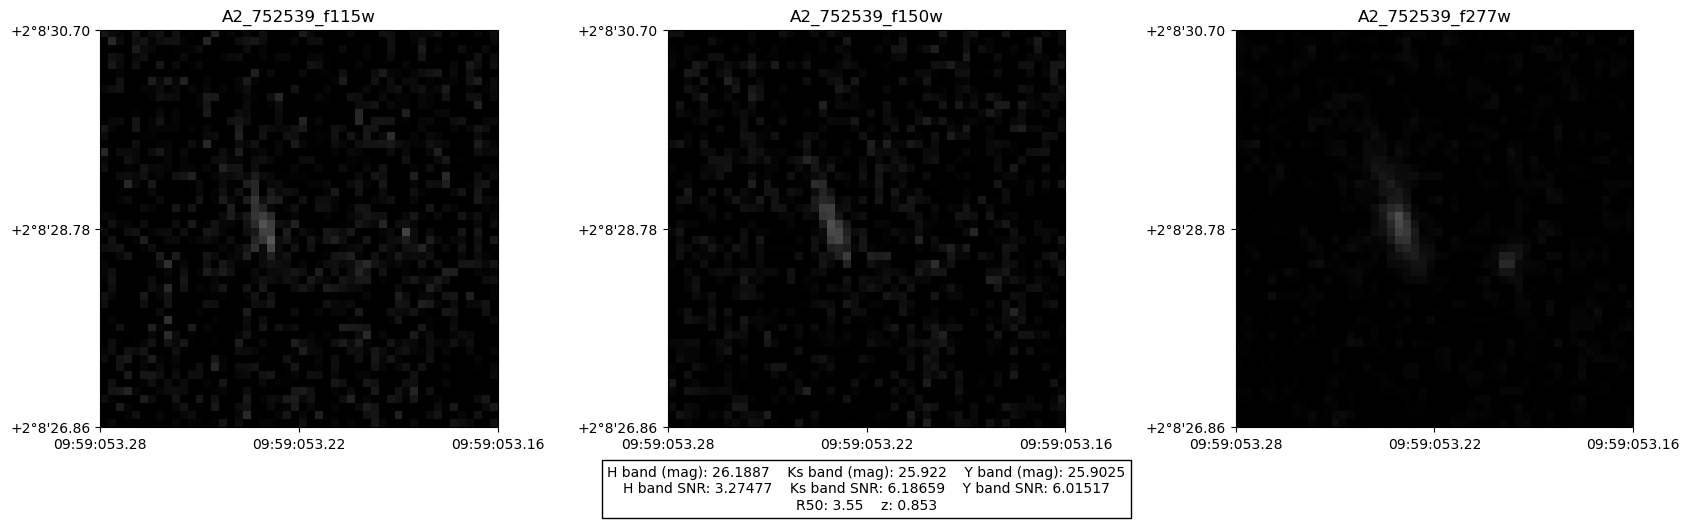

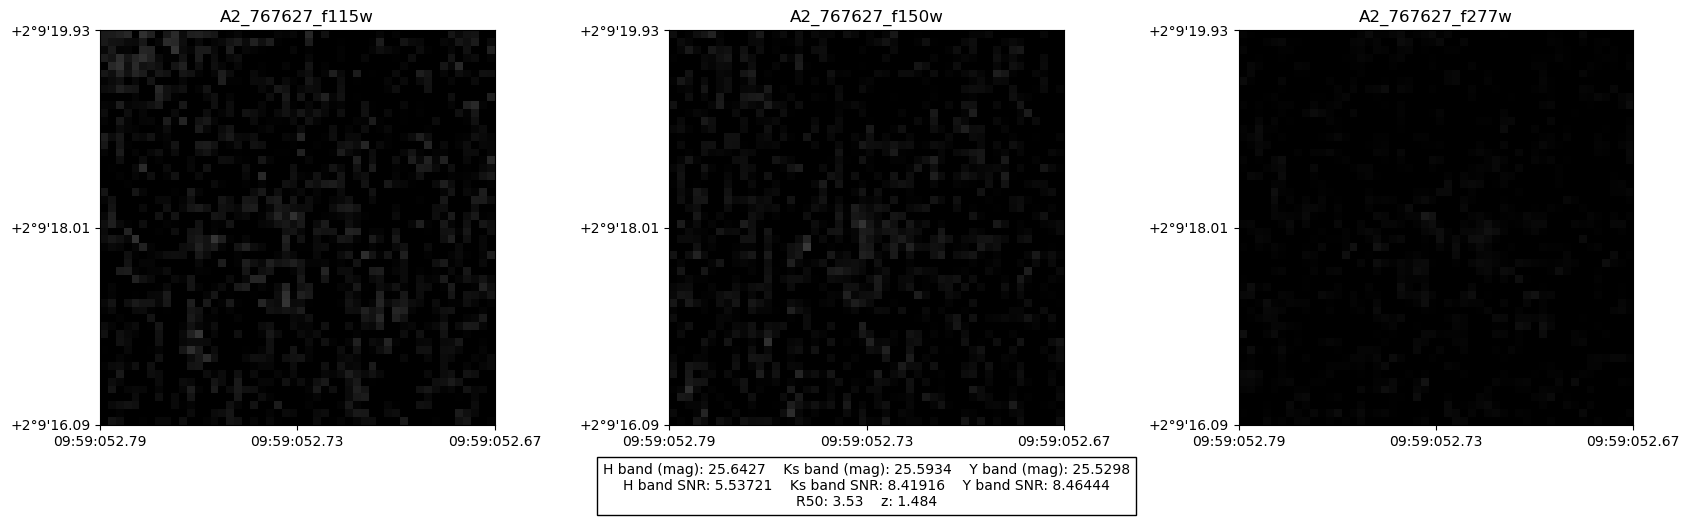

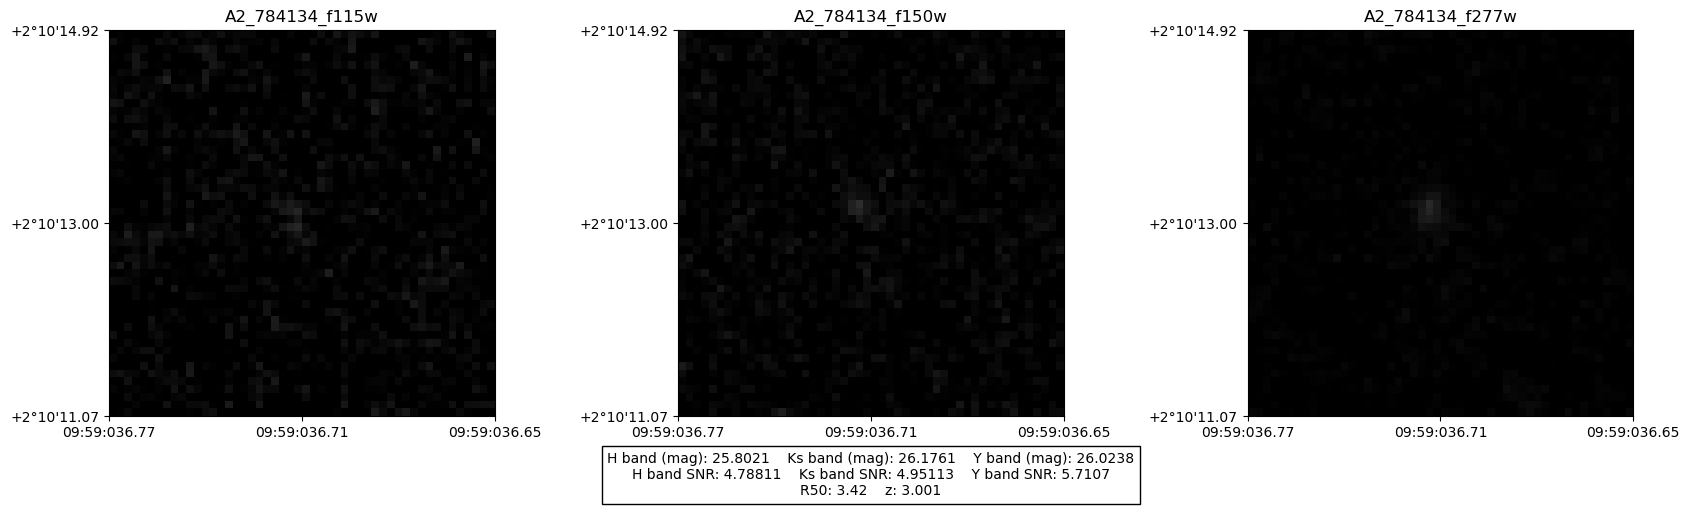

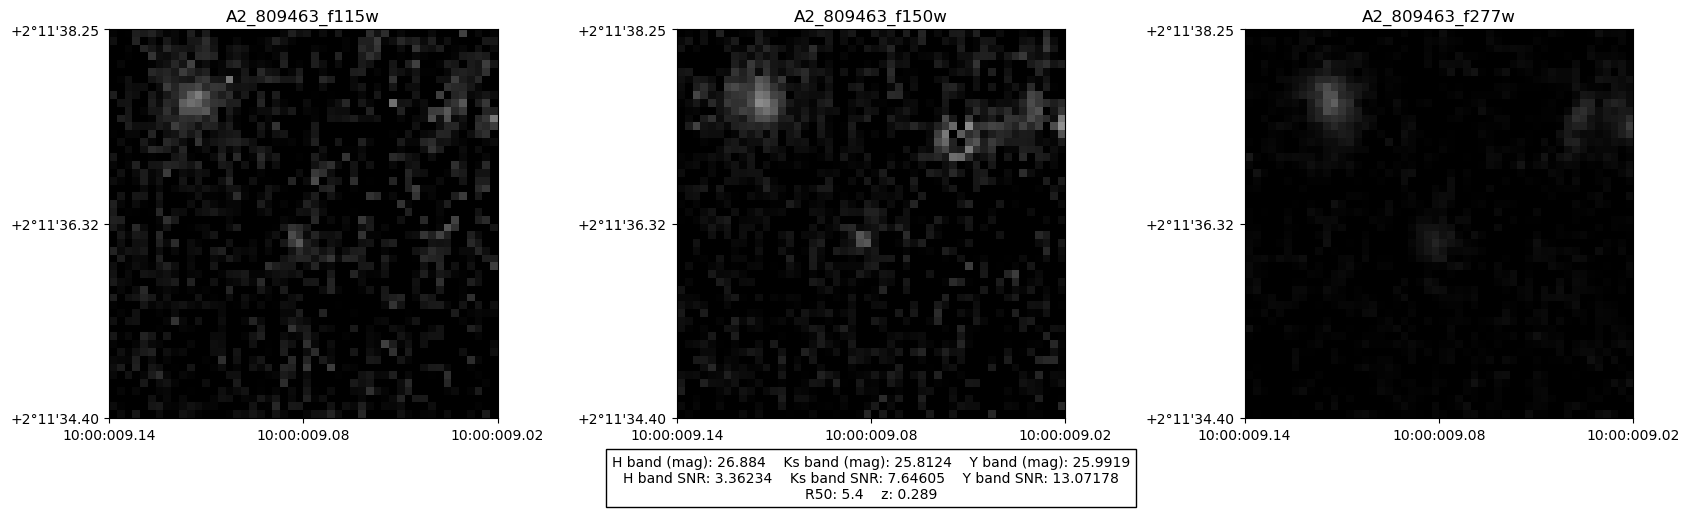

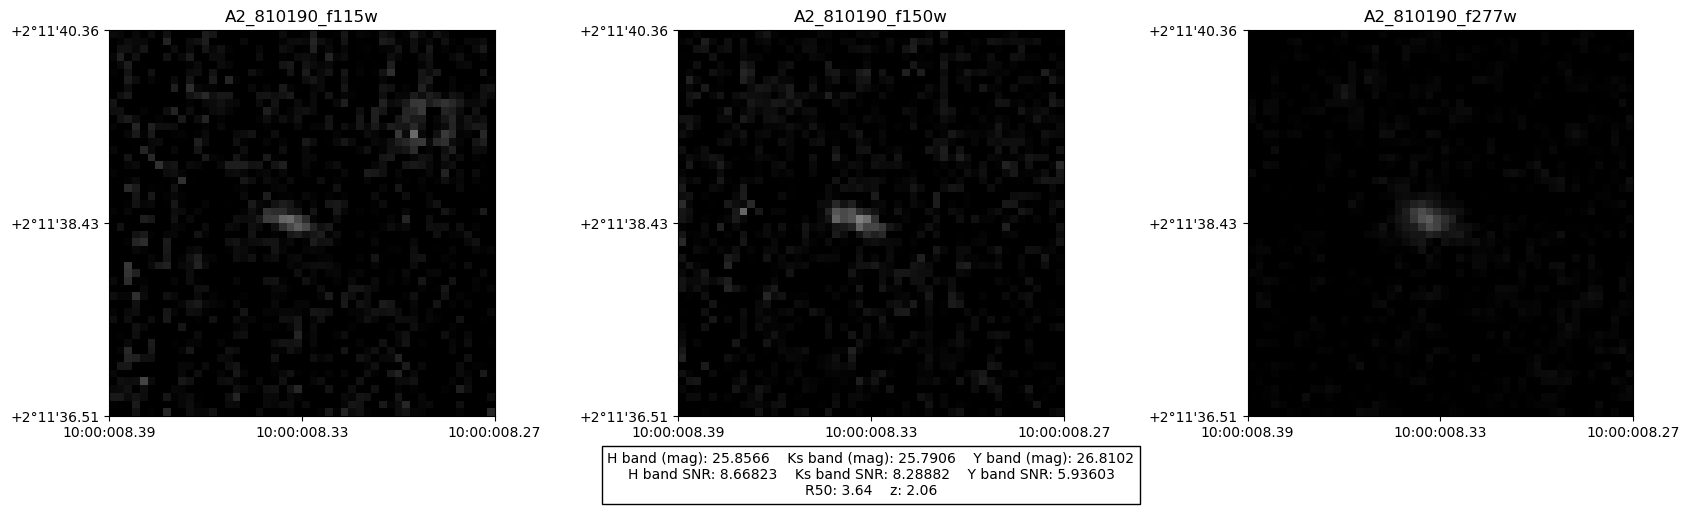

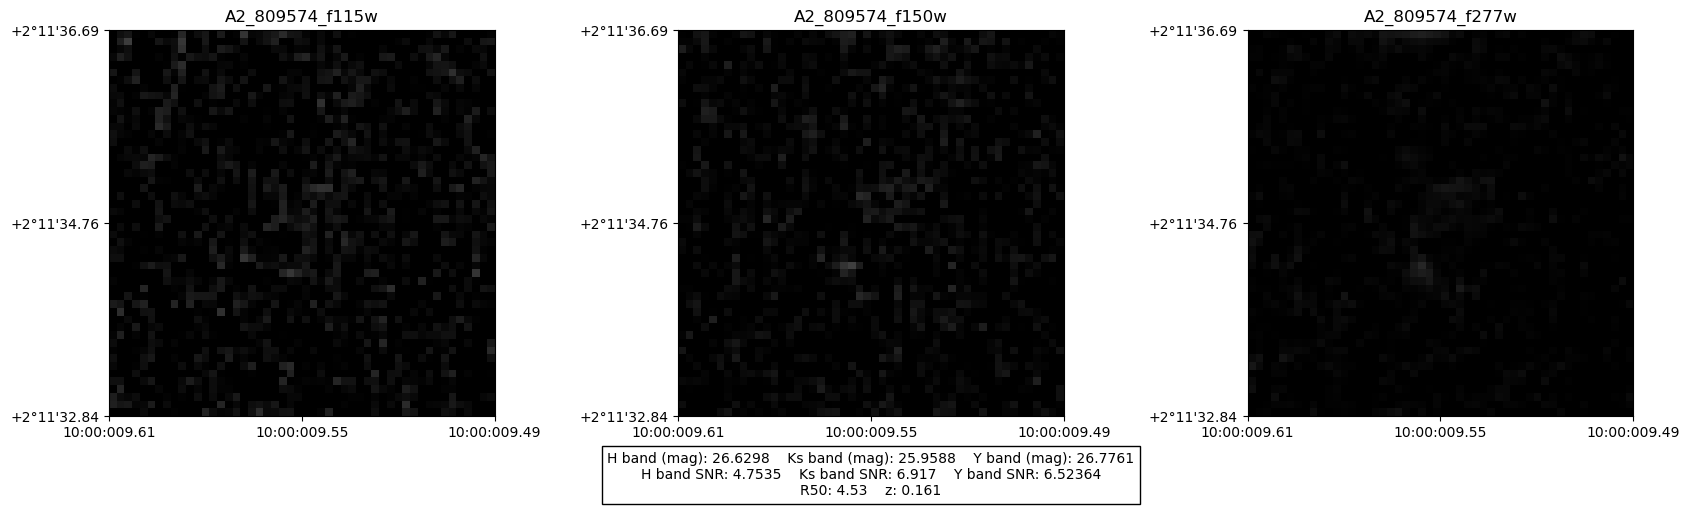

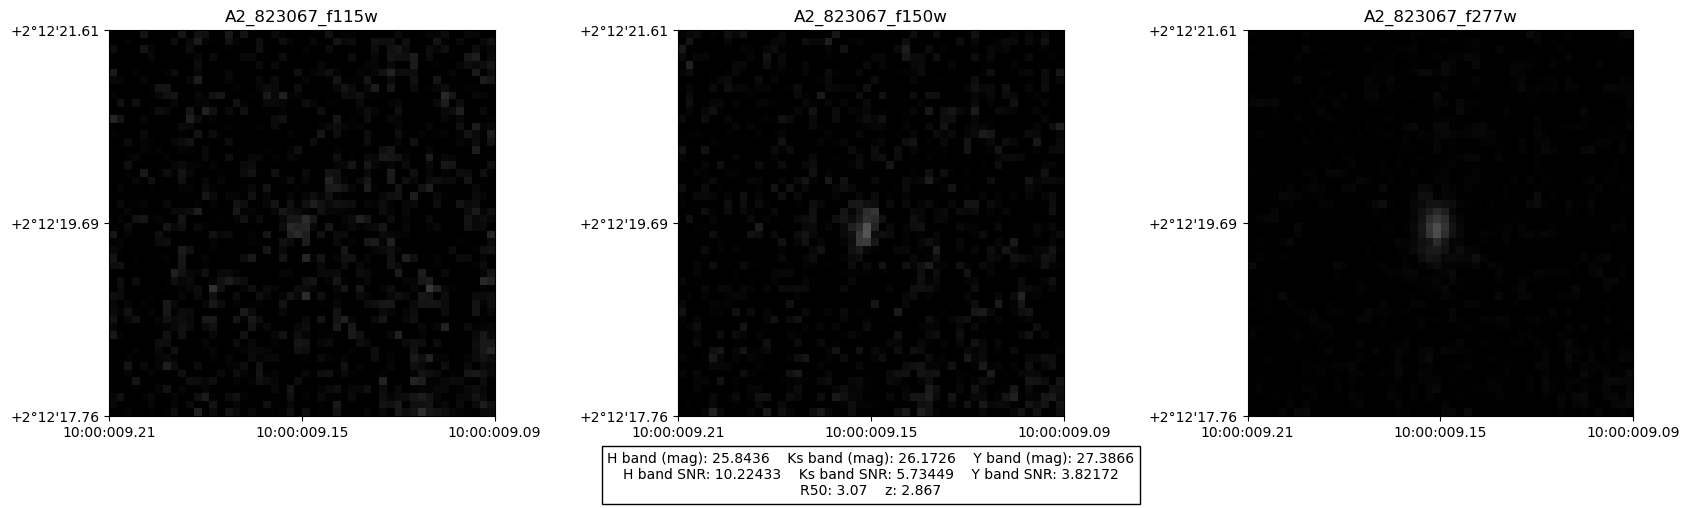

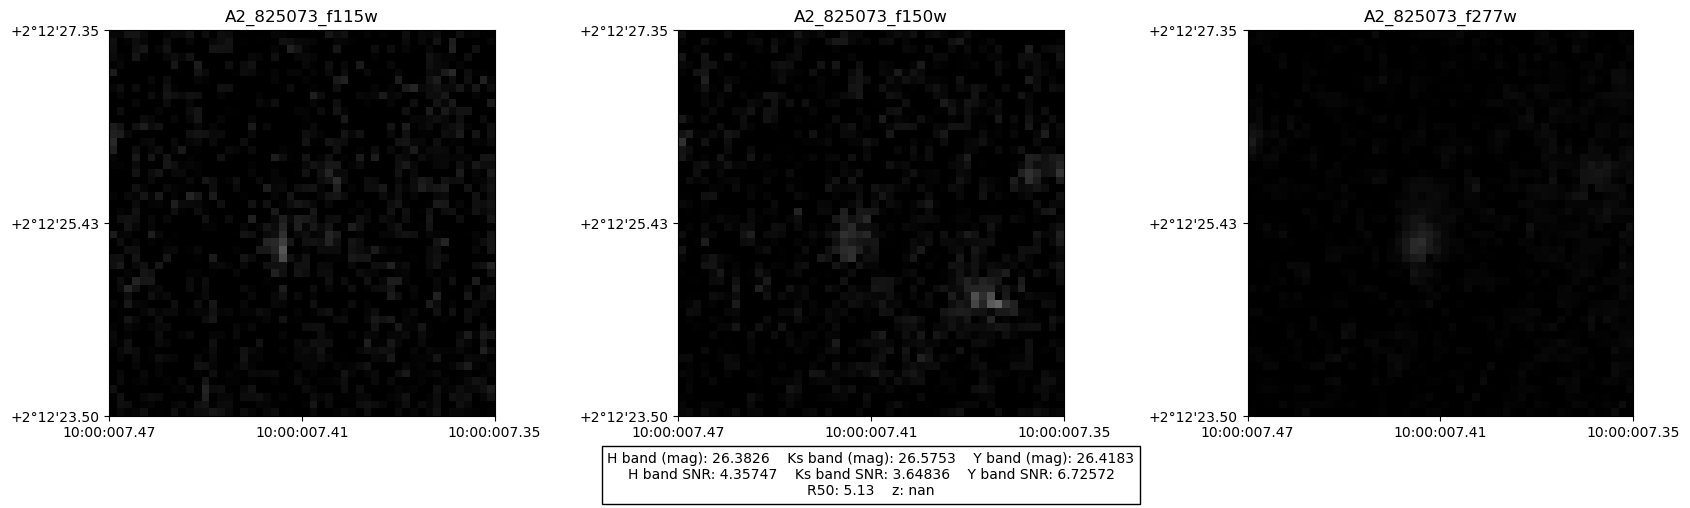

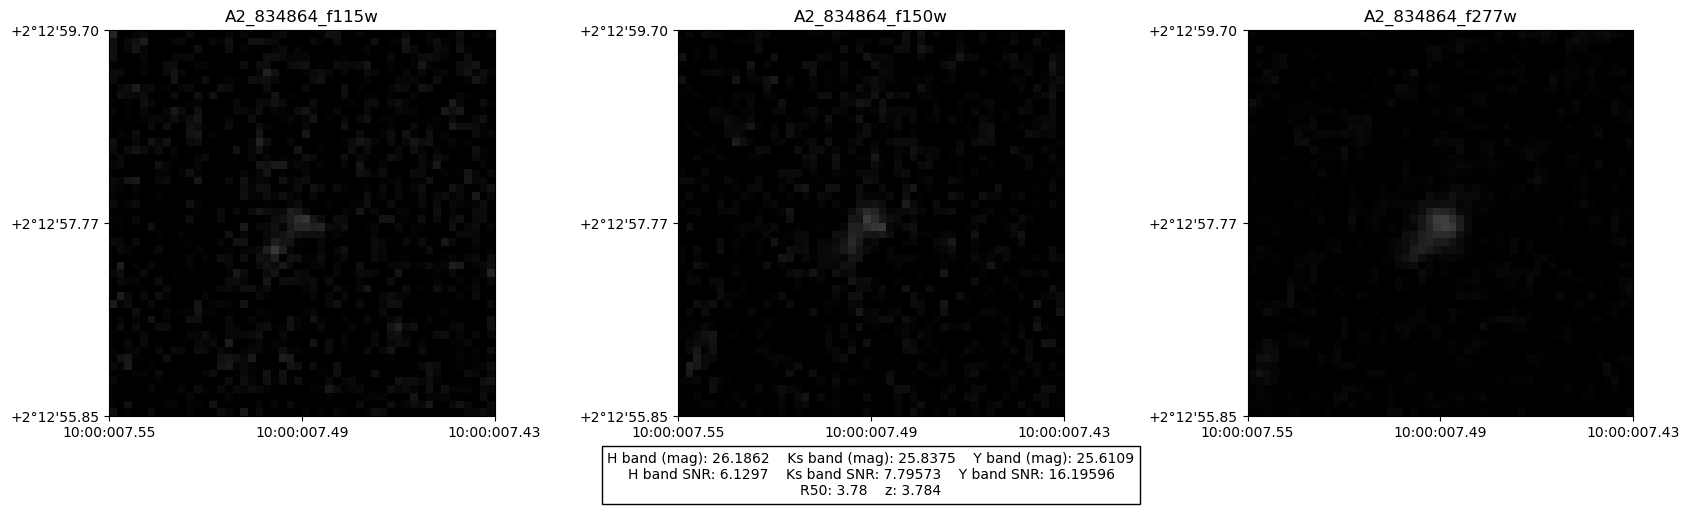

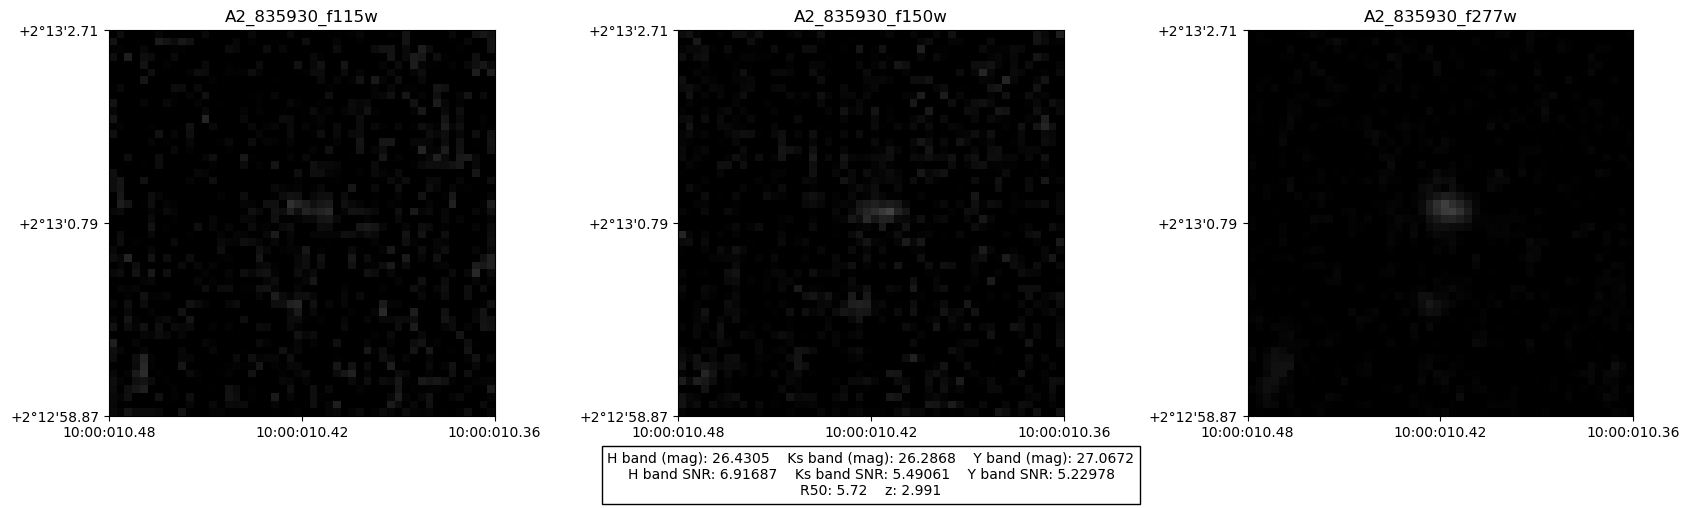

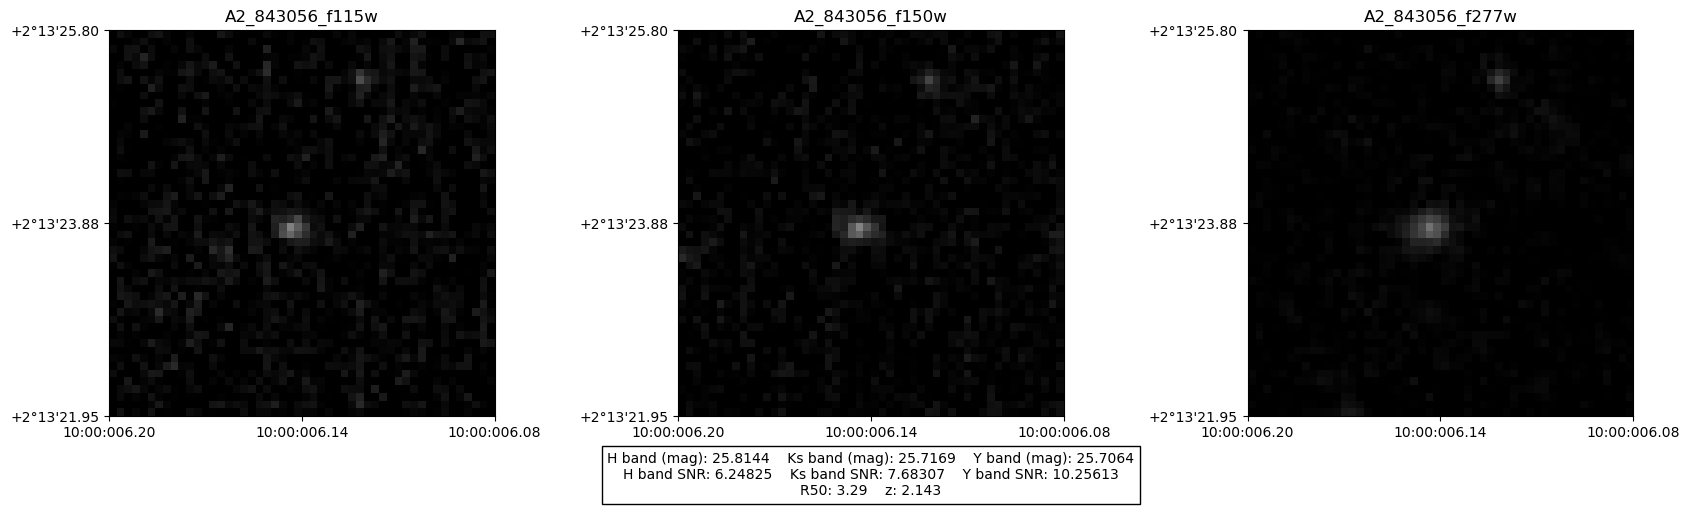

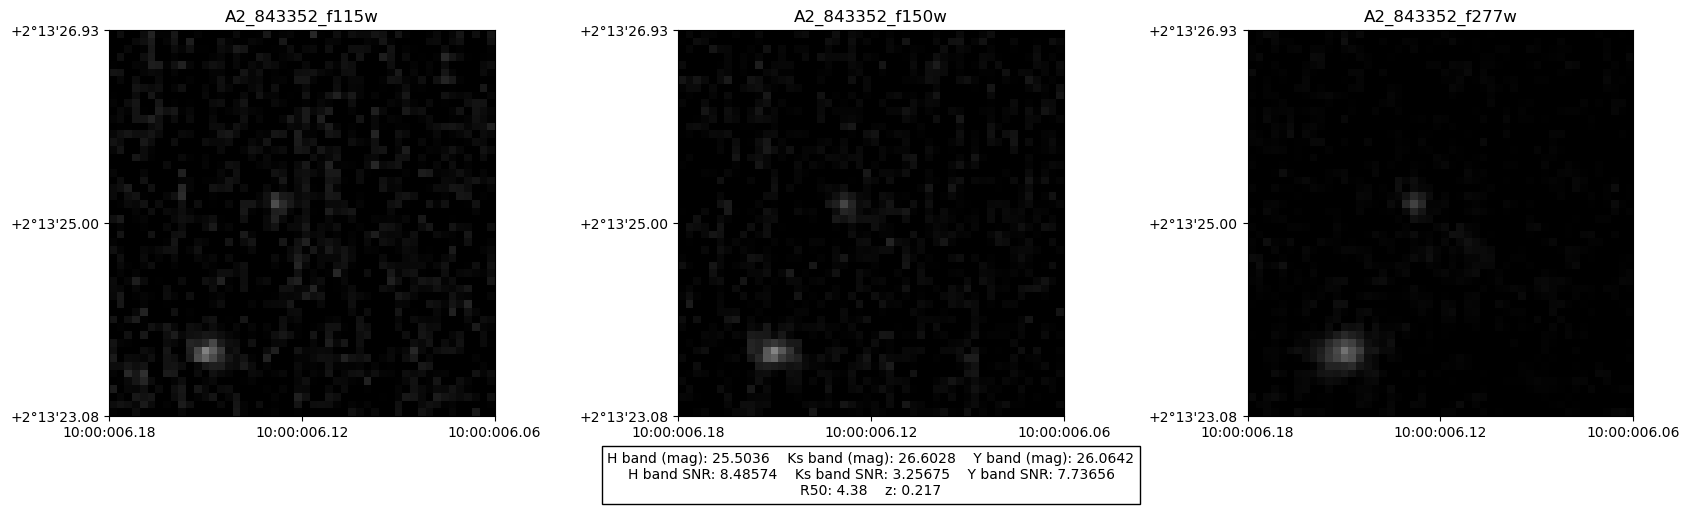

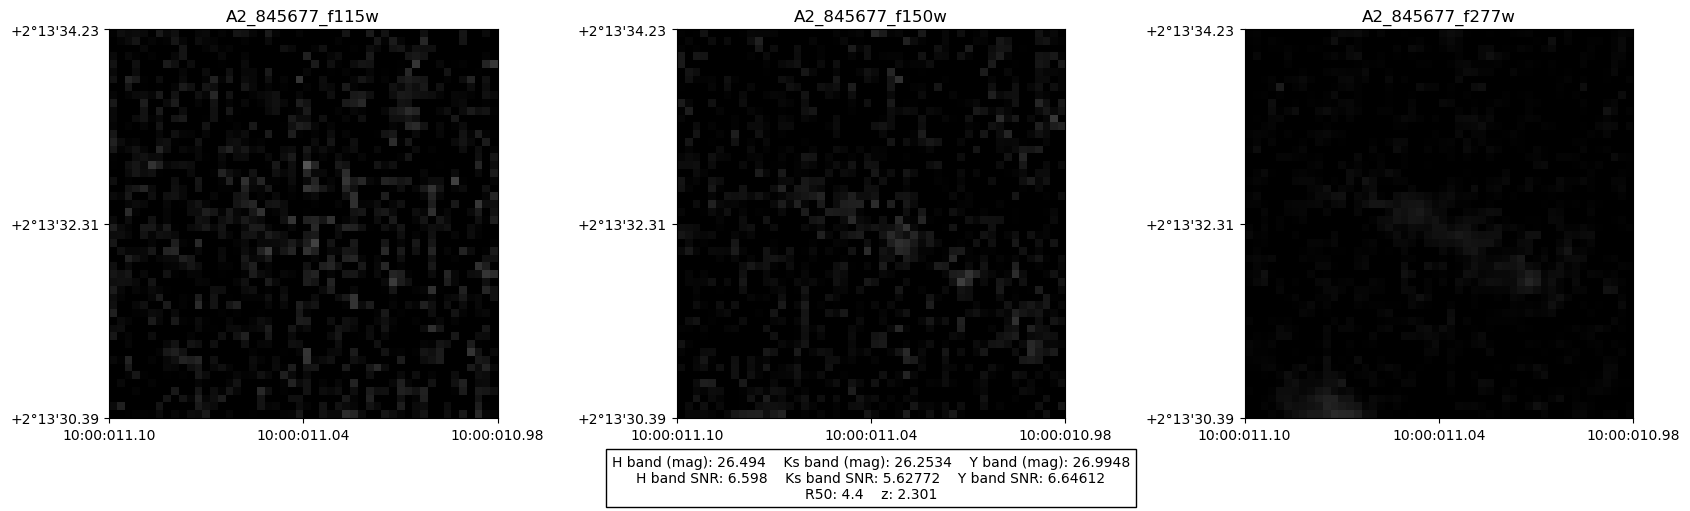

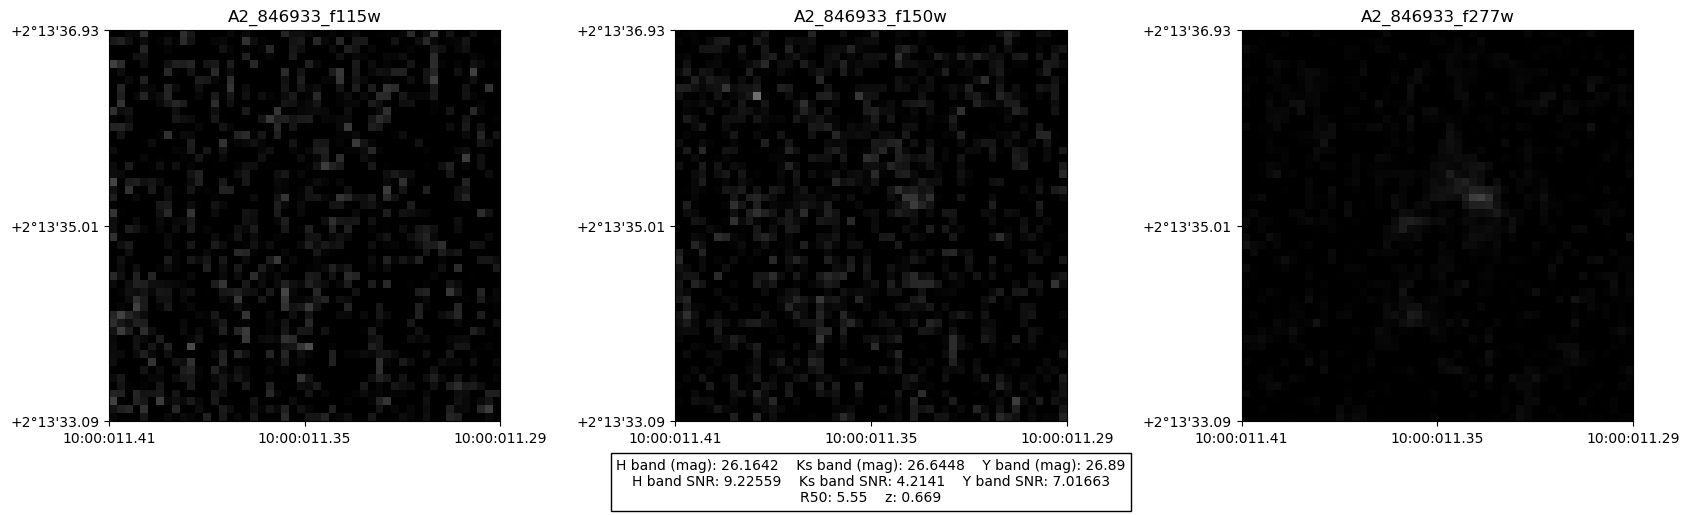

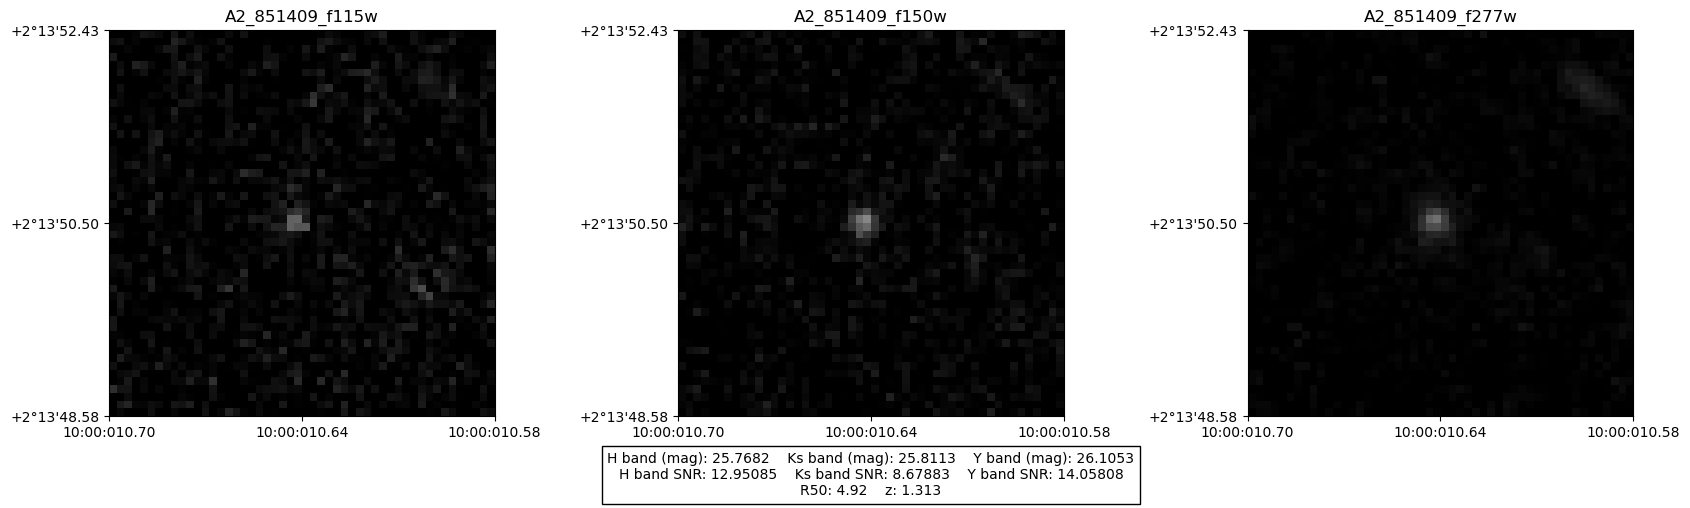

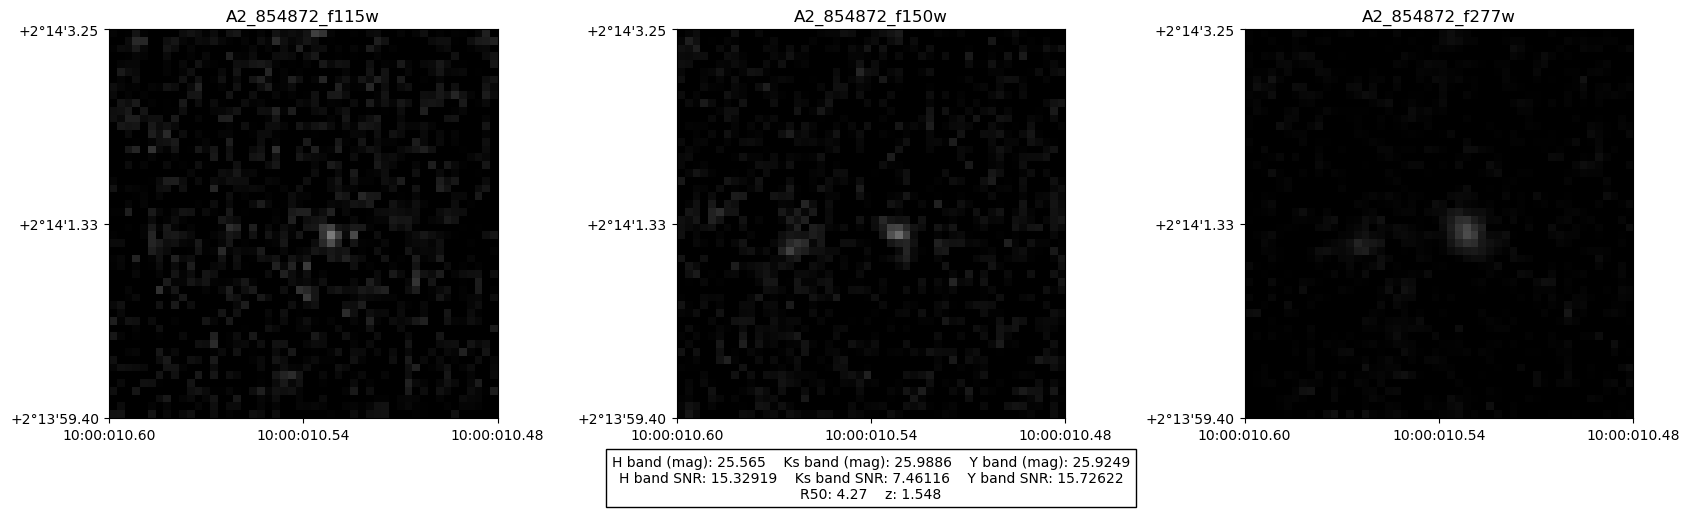

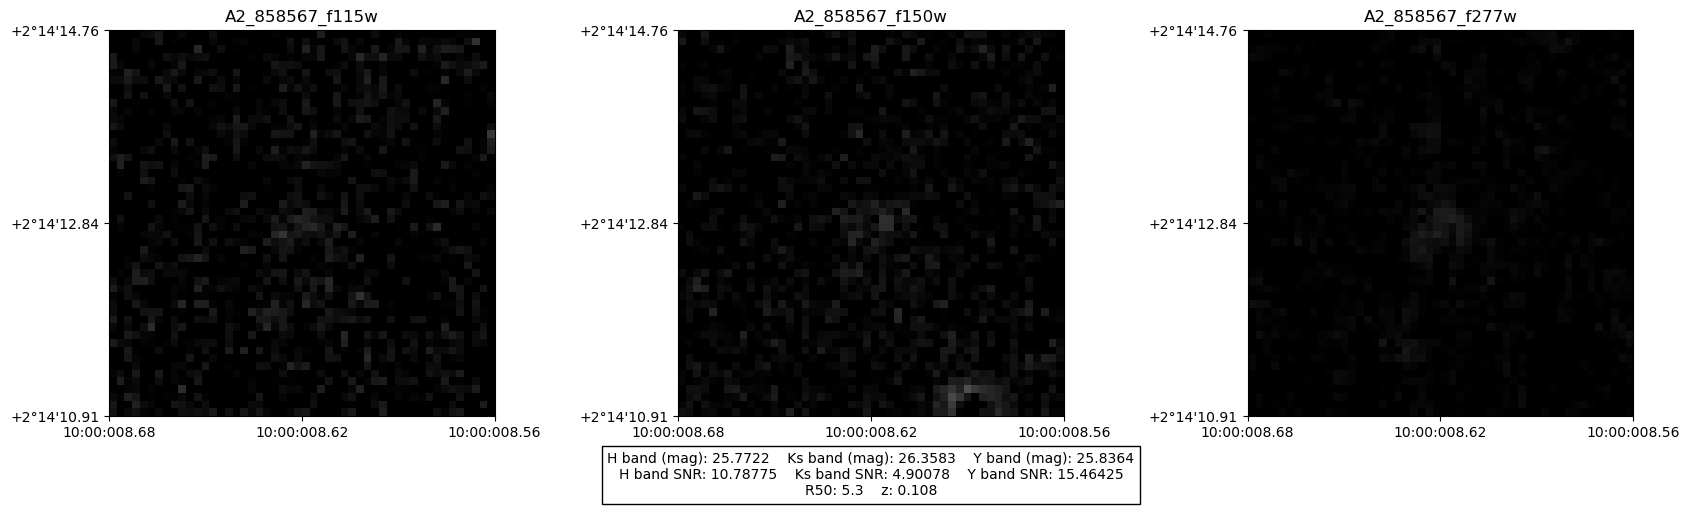

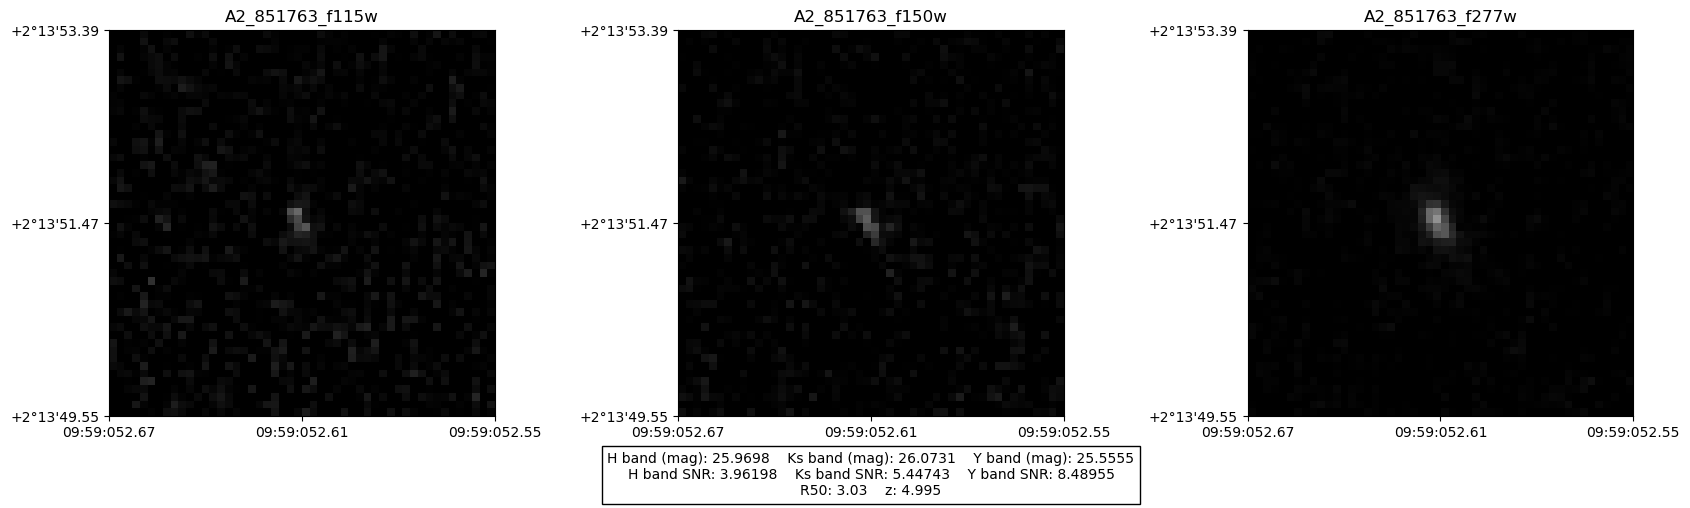

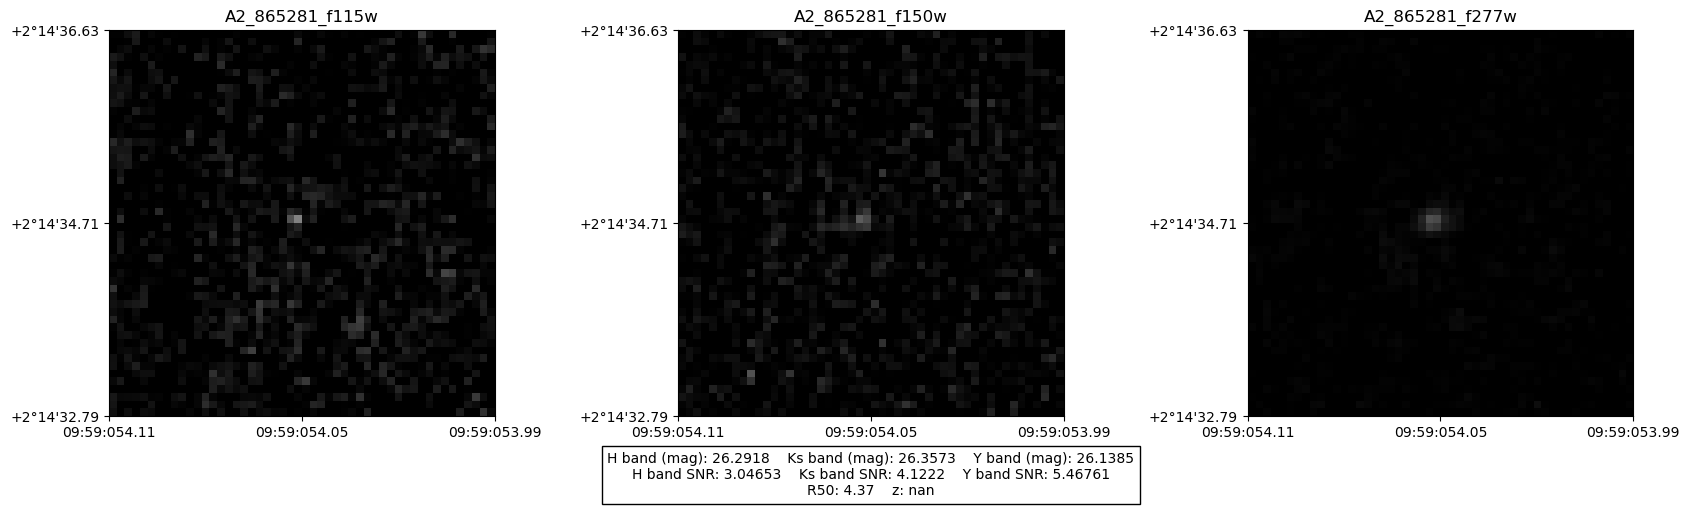

KeyboardInterrupt: 

In [31]:
import pandas as pd
gals = pd.read_csv('output/found_galaxies_1.txt')
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

import math

def decimal_2_dec(decimal):
    sign = "+" if decimal >= 0 else "-"
    degrees = math.floor(abs(decimal))
    minutes = math.floor((abs(decimal) - degrees) * 60)
    seconds = ((abs(decimal) - degrees) * 60 - minutes) * 60
    return f"{sign}{int(degrees)}°{int(minutes)}'{seconds:.2f}"

def decimal_2_ra(decimal):
    hours = int(decimal / 15)  # 360 degrees / 24 hours = 15 degrees/hour
    minutes = int((decimal / 15 - hours) * 60)
    seconds = (decimal / 15 - hours - minutes / 60) * 3600

    return f"{hours:02}:{minutes:02}:{seconds:06.2f}"

from os import listdir
import matplotlib.pyplot as plt
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")
# read in section lists
sections = {}
for sec in ['A2', 'A6', 'E1', 'A10', 'A1', 'A9', 'A4', 'A8', 'A7', 'A3', 'A5']:
    sections.update({sec : (gals[gals['Section']==sec]).reset_index()})

for sec in ['A2', 'A6', 'E1', 'A10', 'A1', 'A9', 'A4', 'A8', 'A7', 'A3', 'A5']:
    pics = {}
    for band in ['115','150','277']:
        pics.update({band : fits.getdata('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=1)})
    w = WCS(fits.getheader('fits/nircam/'+sec+"/mosaic_nircam_f150w_COSMOS-Web_60mas_"+sec+'_v0_5_i2d.fits.gz',ext=1))
    for i in range(len(sections[sec])):
        num_images  = 3
        num_cols    = 3
        num_rows    = 1
        # Create a grid of subplots.
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(17,6))
        list_axes = list(axes.flat)
        for n,band in enumerate(['115','150','277']): # for each object
            xpix, ypix = w.all_world2pix(sections[sec]['RAJ2000'][i],sections[sec]['DEJ2000'][i],1) # convert from RA/DEC to pixel position
            xpix = round(float(xpix))
            ypix = round(float(ypix))
            rpix = round(float(25)) # COSMOS pix * pix/deg = deg / (pix/deg) = pix radius
            #print(xpix,ypix,rpix) # debug print file values
            #print(f'ra:{sections[sec]['RAJ2000'][i]},dec:{sections[sec]['DEJ2000'][i]}') # debug: print object ra/dec
            #print(f'ra:{decimal_2_ra(sections[sec]['RAJ2000'][i])},dec:{decimal_2_dec(sections[sec]['DEJ2000'][i])}') # debug: print object ra/dec in formatted string
            # get image bounds for stamp
            left = int((xpix-rpix))
            right = int((xpix+rpix))
            down = int((ypix-rpix))
            up = int((ypix+rpix))
            #print(left,right,up,down) # debug print image bounds
            # get coordinate range from left to right and up to down on the image
            leftra, downdec = w.all_pix2world(left,down,1)
            rightra, updec = w.all_pix2world(right,up,1)
            # print(leftra,rightra,updec,downdec) # debug: print image bounds coordinates
            # crop image with matplotlib
            list_axes[n].imshow(pics[band][down:up,left:right],cmap='gray',vmin=0,vmax=0.35,origin='lower',extent=[0,1,0,1],aspect='auto')
            list_axes[n].set_aspect('equal', adjustable='box')
            # print(f'xlabels:{np.linspace(rightra,leftra,3)}') # debug, print calculated image bound coordinates spaced
            list_axes[n].set_xticks([0,0.5,1],labels=[decimal_2_ra(np.linspace(leftra,rightra,3)[i]) for i in range(3)])
            list_axes[n].set_yticks([0,0.5,1],labels=[decimal_2_dec(np.linspace(downdec,updec,3)[i]) for i in range(3)])
            list_axes[n].set_title(f'{sec}_{sections[sec]['Classic'][i]}_f{band}w')
        list_axes[1].text(0.5, -0.20, 
            f"H band (mag): {round(sections[sec]['UVISTAHmag'][i],5)}    Ks band (mag): {round(sections[sec]['UVISTAKsmag'][i],5)}    Y band (mag): {round(sections[sec]['UVISTAYmag'][i],5)}\nH band SNR: {round(sections[sec]['SNR_FUVISTAH'][i],5)}    Ks band SNR: {round(sections[sec]['SNR_FUVISTAKs'][i],5)}    Y band SNR: {round(sections[sec]['SNR_FUVISTAY'][i],5)}\nR50: {round(sections[sec]['radFlux'][i],2)}    z: {round(sections[sec]['EZzphot'][i],3)}", 
            horizontalalignment='center', wrap=True, bbox = (dict(facecolor='white', alpha=1)))
        plt.tight_layout()
        plt.savefig(f'output/Comparisons/{sec}_{sections[sec]['Classic'][i]}_allbands',dpi=75)
        plt.show()

Finally! After all this work, we get a bunch of blurry and bad images of galaxies. This tells us something important; that our criteria for picking testable galaxies is wrong.

Let's try to take galaxies that we know have viable quality, and then update our criteria to match.

In [33]:
def find_closest_values(df, target_value1, target_value2, col1, col2):
    df['distance'] = np.sqrt((df[col1] - target_value1)**2 + (df[col2] - target_value2)**2)
    return df.loc[df['distance'].idxmin()]

This function lets us search our catalog for the individual galaxies and their properties. We just need the coordinates.

In [32]:
import pandas as pd
# Load the galaxy data and FITS file ranges
obj = pd.read_csv('input/COSMOSPHOT_SNR.csv', sep=',', header=0)

In [34]:
obj

,Classic,DEJ2000,EZzphot,lpzBEST,RAJ2000,radFlux,UVISTAYmag,UVISTAHmag,FUVISTAKs,e_FUVISTAKs,...,e_UVISTAKsmag,FUVISTAY,e_FUVISTAY,e_UVISTAYmag,FUVISTAH,e_UVISTAHmag,e_FUVISTAH,SNR_FUVISTAH,SNR_FUVISTAY,SNR_FUVISTAKs
0,275886,1.677451,0.573705,NaN,149.809627,4.42,21.5977,21.3176,14.41,0.035428,...,0.002669,8.34,0.015957,0.002079,10.79,0.002348,0.023336,462.371766,522.654634,406.741579
1,275134,1.680061,0.787219,0.7352,149.888246,4.02,23.8737,23.7232,1.77,0.053852,...,0.032996,1.02,0.066159,0.070111,1.18,0.090931,0.098561,11.972293,15.417404,32.867738
2,272305,1.677908,1.399695,1.3698,149.879218,4.77,23.8501,23.7618,1.28,0.051221,...,0.043577,1.05,0.052477,0.054415,1.14,0.074841,0.078288,14.561674,20.008918,24.989702
3,271753,1.678074,1.246581,1.5063,149.876875,3.34,NaN,26.4426,0.28,0.035810,...,0.137273,-0.01,0.031748,NaN,0.10,0.529906,0.046928,2.130929,-0.314977,7.819154
4,274033,1.680335,0.412991,1.7611,149.881965,8.36,NaN,25.1853,0.04,0.038734,...,0.969397,-0.02,0.047389,NaN,0.31,0.248853,0.070160,4.418447,-0.422037,1.032682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236448,994776,2.360402,2.055357,2.3198,149.798346,4.58,23.4797,22.7098,3.29,0.027753,...,0.009149,1.47,0.013237,0.009759,2.99,0.007329,0.020201,148.011009,111.048998,118.545316
236449,996015,2.362869,2.989083,2.8236,149.800852,4.09,26.2089,26.6471,0.11,0.024174,...,0.235096,0.12,0.011451,0.104260,0.08,0.238859,0.017522,4.565663,10.479434,4.550381
236450,998266,2.364107,10.629337,7.3993,149.802372,NaN,26.0901,NaN,0.10,0.019899,...,0.224152,0.13,0.009942,0.081138,-0.08,NaN,0.014630,-5.468066,13.076313,5.025403
236451,998586,2.365249,4.870573,4.0625,149.802850,0.95,27.3039,26.2378,0.15,0.018123,...,0.129263,0.04,0.008727,0.217848,0.12,0.122864,0.013140,9.132698,4.583345,8.276730


Here is our (relatively small) list of discernable galaxies, from which we can see what trending variables might make them discernable in the COSMOS-Web images.\
Name    RA  DEC radius(deg)\
Big Guy	150.4248302	2.0665166	0.0027812\
Number 6	150.1651867	2.0623849	0.0009054\
Long One	149.8668852	2.0517563	0.0009977\
IDK	149.8761022	2.0727377	0.0004669\
Another Big	150.2793003	1.9046633	0.0031161\
Spiral Dude	149.99659545	2.1196391	0.0009638\
Galaxy	150.3606778	1.9880293	0.0014217\
Number 17	150.1780776	1.9358321	0.0006253

In [37]:
print('Number 6')
print(find_closest_values(obj,150.1651867,2.0623849,'RAJ2000','DEJ2000'))
print('Big Guy')
print(find_closest_values(obj,150.4248302,2.0665166,'RAJ2000','DEJ2000'))
print('Another Big')
print(find_closest_values(obj,150.2793003,1.9046633,'RAJ2000','DEJ2000'))
print('Long One')
print(find_closest_values(obj,149.8668852,2.0517563,'RAJ2000','DEJ2000'))
print('Galaxy')
print(find_closest_values(obj,150.3606778,1.9880293,'RAJ2000','DEJ2000'))
print('Number 17')
print(find_closest_values(obj,150.1780776,1.9358321,'RAJ2000','DEJ2000'))

Number 6
Classic          678911.000000
DEJ2000               2.062381
EZzphot               0.220893
lpzBEST               0.216600
RAJ2000             150.165173
radFlux               5.270000
UVISTAYmag           17.970800
UVISTAHmag           17.371700
FUVISTAKs           487.870000
e_FUVISTAKs           0.032266
UVISTAKsmag          17.179200
e_UVISTAKsmag         0.000072
FUVISTAY            235.340000
e_FUVISTAY            0.014827
e_UVISTAYmag          0.000068
FUVISTAH            408.630000
e_UVISTAHmag          0.000060
e_FUVISTAH            0.022524
SNR_FUVISTAH      18141.981886
SNR_FUVISTAY      15872.502006
SNR_FUVISTAKs     15120.250418
distance              0.000014
Name: 146700, dtype: float64
Big Guy
Classic          675983.000000
DEJ2000               2.067894
EZzphot               0.708622
lpzBEST                    NaN
RAJ2000             150.412629
radFlux               4.020000
UVISTAYmag           24.295600
UVISTAHmag           23.263200
FUVISTAKs             2.

It seems our best bet to get clear images is to up the required S/N ratios.

In [ ]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from os import listdir
import math
import multiprocessing as mp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Define the path to the FITS files
path = r"/home/eliasw/OneDrive/Research/Deconvolution/fits/miri"

obj = pd.read_csv('input/COSMOSPHOT_SNR.csv', sep=',', header=0)

snrFlag = ((obj['SNR_FUVISTAH'] > 50) & (obj['SNR_FUVISTAKs'] > 50) & (obj['SNR_FUVISTAY'] > 50))

obj = obj[snrFlag == True].reset_index()
ranges = pd.read_csv('fits/fitsrange.txt', sep=',', header=0)

# Preload FITS headers and data
def preload_fits_files(path):
    fits_data = {}
    for file in listdir(path):
        if file.endswith('.fits.gz'):  # Ensure it's a FITS file
            header = WCS(fits.getheader(path + '/' + file, ext=1), fix=False)  # Get WCS header for pixel to RA/Dec conversion
            mask = fits.getdata((path + '/mask/' + file).replace('.fits.gz','_mask.fits'))  # Load only the necessary data extension
            fits_data[file] = {'wcs': header, 'mask': mask}
    return fits_data

# Function to search for galaxies in preloaded FITS files for a subset of galaxies
def search_galaxies(start_index, end_index, fits_data):
    foundgals = 0
    found_objects = []
        
    end_index = min(end_index, len(obj)) #indexing fix
    #print(f"Processing indices from {start_index} to {end_index}")

    for i in range(start_index, end_index):
       # print(f"Checking index {i}, Galaxy ID {obj['Classic'][i]}") 
        for file, file_data in fits_data.items():  # Loop through preloaded FITS data
            ramin = (ranges[ranges['File'] == file]['RAmin'])
            ramax = (ranges[ranges['File'] == file]['RAmax'])
            decmin = (ranges[ranges['File'] == file]['DECmin'])
            decmax = (ranges[ranges['File'] == file]['DECmax'])
            ramin = float(ramin)
            ramax = float(ramax)
            decmin = float(decmin)
            decmax = float(decmax)
            # Check if the galaxy is within the RA/Dec range of the file
            if ramin <= obj['RAJ2000'][i]:
                if obj['RAJ2000'][i] <= ramax:
                    if decmin <= obj['DEJ2000'][i]:
                        if obj['DEJ2000'][i] <= decmax:
                            w = file_data['wcs']  # Get the preloaded WCS header
                            xpix, ypix = w.all_world2pix(obj['RAJ2000'][i], obj['DEJ2000'][i], 1)
                            # Check if the pixel coordinates are within bounds
                            if (0 <= xpix <= 9600 and 0 <= ypix <= 12455):
                                if (file_data['mask'][int(ypix),int(xpix)] == True):  # if data at position in mask
                                    foundgals += 1
                                    #print(f"Galaxy found at index {i}, ID {obj['Classic'][i]} in file {file}, at coords {obj['RAJ2000'][i]} RA and {obj['DEJ2000'][i]} DEC")
                                    found_objects.append([obj['Classic'][i], obj['RAJ2000'][i], obj['DEJ2000'][i],obj['EZzphot'][i], obj['radFlux'][i], obj['SNR_FUVISTAH'][i], obj['UVISTAHmag'][i], obj['e_UVISTAHmag'][i], obj['FUVISTAH'][i], obj['e_FUVISTAH'][i], obj['SNR_FUVISTAKs'][i], obj['UVISTAKsmag'][i], obj['e_UVISTAKsmag'][i], obj['FUVISTAKs'][i], obj['e_FUVISTAKs'][i], obj['SNR_FUVISTAY'][i], obj['UVISTAYmag'][i], obj['e_UVISTAYmag'][i], obj['FUVISTAY'][i], obj['e_FUVISTAY'][i], file])  # Save RA, Dec, and file
                                    break  # Stop searching this file if galaxy found

    return foundgals, found_objects

# Multi-core processing: split the galaxy list into chunks
if __name__ == '__main__':
    num_cores = mp.cpu_count()  # Use all available cores
    chunk_size = len(obj) // num_cores  # Determine the size of each chunk

    # Preload all FITS files and headers before starting the search
    fits_data = preload_fits_files(path)

    # Create a pool of workers and distribute the work
    with mp.Pool(num_cores) as pool:
        results = [pool.apply_async(search_galaxies, args=(i, i + chunk_size, fits_data)) for i in range(0, len(obj), chunk_size)]
        
        found_gals = 0
        found_objects = []

        for result in results:
            chunk_found_gals, chunk_found_details = result.get()  # Get both elements from the result tuple
            found_gals += chunk_found_gals  # Sum the galaxy count
            found_objects.extend(chunk_found_details)  # Add the found details to the main list

        # Write the results to a file
        with open('output/eli_found_galaxies.txt', 'w') as out:
            #out.write(f'Found {found_gals} galaxies out of {len(obj)}\n')
            out.write('Classic,RAJ2000,DEJ2000,EZzphot,radFlux,SNR_FUVISTAH,UVISTAHmag,e_UVISTAHmag,FUVISTAH,e_FUVISTAH,SNR_FUVISTAKs,UVISTAKsmag,e_UVISTAKsmag,FUVISTAKs,e_FUVISTAKs,SNR_FUVISTAY,UVISTAYmag,e_UVISTAYmag,FUVISTAY,e_FUVISTAY,Section\n')  # Header for the galaxy details
            for gal in found_objects:
                out.write(f'{gal[0]},{gal[1]},{gal[2]},{gal[3]},{gal[4]},{gal[5]},{gal[6]},{gal[7]},{gal[8]},{gal[9]},{gal[10]},{gal[11]},{gal[12]},{gal[13]},{gal[14]},{gal[15]},{gal[16]},{gal[17]},{gal[18]},{gal[19]},{gal[20].replace('mosaic_miri_f770w_COSMOS-Web_60mas_',"").replace('_v0_5_i2d.fits.gz','')}\n')  # Write each galaxy's details (ID,RA, Dec, redshift, fluxradius, photometrics, and file)
            out.flush()


gals = pd.read_csv('output/eli_found_galaxies.txt')


def decimal_2_dec(decimal):
    sign = "+" if decimal >= 0 else "-"
    degrees = math.floor(abs(decimal))
    minutes = math.floor((abs(decimal) - degrees) * 60)
    seconds = ((abs(decimal) - degrees) * 60 - minutes) * 60
    return f"{sign}{int(degrees)}°{int(minutes)}'{seconds:.2f}"

def decimal_2_ra(decimal):
    hours = int(decimal / 15)  # 360 degrees / 24 hours = 15 degrees/hour
    minutes = int((decimal / 15 - hours) * 60)
    seconds = (decimal / 15 - hours - minutes / 60) * 3600

    return f"{hours:02}:{minutes:02}:{seconds:06.2f}"

# read in section lists
sections = {}
for sec in ['A2', 'A6', 'E1', 'A10', 'A1', 'A9', 'A4', 'A8', 'A7', 'A3', 'A5']:
    sections.update({sec : (gals[gals['Section']==sec]).reset_index()})

for sec in ['A2', 'A6', 'E1', 'A10', 'A1', 'A9', 'A4', 'A8', 'A7', 'A3', 'A5']:
    pics = {}
    for band in ['115','150','277']:
        pics.update({band : fits.getdata('fits/nircam/'+sec+'/'+'mosaic_nircam_f'+band+'w_COSMOS-Web_60mas_'+sec+'_v0_5_i2d.fits.gz',ext=1)})
    w = WCS(fits.getheader('fits/nircam/'+sec+"/mosaic_nircam_f150w_COSMOS-Web_60mas_"+sec+'_v0_5_i2d.fits.gz',ext=1))
    for i in range(len(100)):
        num_images  = 3
        num_cols    = 3
        num_rows    = 1
        # Create a grid of subplots.
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(17,6))
        list_axes = list(axes.flat)
        for n,band in enumerate(['115','150','277']): # for each object
            xpix, ypix = w.all_world2pix(sections[sec]['RAJ2000'][i],sections[sec]['DEJ2000'][i],1) # convert from RA/DEC to pixel position
            xpix = round(float(xpix))
            ypix = round(float(ypix))
            rpix = round(float(25)) # COSMOS pix * pix/deg = deg / (pix/deg) = pix radius
            #print(xpix,ypix,rpix) # debug print file values
            #print(f'ra:{sections[sec]['RAJ2000'][i]},dec:{sections[sec]['DEJ2000'][i]}') # debug: print object ra/dec
            #print(f'ra:{decimal_2_ra(sections[sec]['RAJ2000'][i])},dec:{decimal_2_dec(sections[sec]['DEJ2000'][i])}') # debug: print object ra/dec in formatted string
            # get image bounds for stamp
            left = int((xpix-rpix))
            right = int((xpix+rpix))
            down = int((ypix-rpix))
            up = int((ypix+rpix))
            #print(left,right,up,down) # debug print image bounds
            # get coordinate range from left to right and up to down on the image
            leftra, downdec = w.all_pix2world(left,down,1)
            rightra, updec = w.all_pix2world(right,up,1)
            # print(leftra,rightra,updec,downdec) # debug: print image bounds coordinates
            # crop image with matplotlib
            list_axes[n].imshow(pics[band][down:up,left:right],cmap='gray',vmin=0,vmax=0.35,origin='lower',extent=[0,1,0,1],aspect='auto')
            list_axes[n].set_aspect('equal', adjustable='box')
            # print(f'xlabels:{np.linspace(rightra,leftra,3)}') # debug, print calculated image bound coordinates spaced
            list_axes[n].set_xticks([0,0.5,1],labels=[decimal_2_ra(np.linspace(leftra,rightra,3)[i]) for i in range(3)])
            list_axes[n].set_yticks([0,0.5,1],labels=[decimal_2_dec(np.linspace(downdec,updec,3)[i]) for i in range(3)])
            list_axes[n].set_title(f'{sec}_{sections[sec]['Classic'][i]}_f{band}w')
        list_axes[1].text(0.5, -0.20, 
            f"H band (mag): {round(sections[sec]['UVISTAHmag'][i],5)}    Ks band (mag): {round(sections[sec]['UVISTAKsmag'][i],5)}    Y band (mag): {round(sections[sec]['UVISTAYmag'][i],5)}\nH band SNR: {round(sections[sec]['SNR_FUVISTAH'][i],5)}    Ks band SNR: {round(sections[sec]['SNR_FUVISTAKs'][i],5)}    Y band SNR: {round(sections[sec]['SNR_FUVISTAY'][i],5)}\nR50: {round(sections[sec]['radFlux'][i],2)}    z: {round(sections[sec]['EZzphot'][i],3)}", 
            horizontalalignment='center', wrap=True, bbox = (dict(facecolor='white', alpha=1)))
        plt.tight_layout()
        plt.savefig(f'output/EliComparisons/{sec}_{sections[sec]['Classic'][i]}_allbands',dpi=75)
        plt.show()

In [16]:
import pandas as pd
# Load the galaxy data and FITS file ranges
obj = pd.read_csv('input/asu.tsv', sep='\t', header=0,skiprows=51,low_memory=False)

In [17]:
print(len(obj))
obj = obj.dropna()
print(len(obj))

272325
256888


In [13]:
obj

,Classic,RAJ2000,DEJ2000,radFlux,FUVISTAY,e_FUVISTAY,UVISTAYmagAuto,e_UVISTAYmagAuto,FUVISTAH,e_FUVISTAH,UVISTAHmagAuto,e_UVISTAHmagAuto,FUVISTAKs,e_FUVISTAKs,UVISTAKsmagAuto,e_UVISTAKsmagAuto,lpzBEST,EZzphot
0,270675,150.394976,1.676908,,0.05,0.027,27.1967,0.60109,0.04,0.047,27.3200,1.20,-0.06,0.045,,,1.832700,1.307051
1,270677,150.354186,1.676918,13.30,-0.07,0.045,,,-0.38,0.080,,,-0.09,0.050,,,3.544400,4.408944
2,270655,149.831375,1.676926,2.69,0.09,0.014,26.5024,0.17213,0.12,0.025,26.1968,0.23,0.19,0.041,25.6817,0.23093,2.021700,2.012880
3,271472,150.302866,1.676939,3.54,0.30,0.075,25.2216,0.27393,1.09,0.131,23.8035,0.13,1.27,0.082,23.6443,0.07035,1.948600,1.965939
4,273767,150.307729,1.676940,6.88,15.54,0.143,20.9216,0.00998,19.15,0.250,20.6944,0.01,19.84,0.157,20.6564,0.00862,0.217200,0.230239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272320,999653,150.286209,2.366080,2.66,0.44,0.038,24.7807,0.09227,0.19,0.061,25.6753,0.34,0.20,0.044,25.6494,0.23713,1.796200,1.817085
272321,1000755,149.980584,2.366081,3.72,1.97,0.051,23.1648,0.02796,1.96,0.084,23.1681,0.05,2.65,0.060,22.8424,0.02465,0.405800,0.410568
272322,1000012,150.120671,2.366087,3.58,0.22,0.011,25.5644,0.05365,0.19,0.019,25.6965,0.11,0.16,0.029,25.8720,0.19623,0.390300,0.416430
272323,1000668,149.947463,2.366087,4.08,1.79,0.051,23.2654,0.03105,2.69,0.086,22.8264,0.03,3.82,0.061,22.4442,0.01735,0.912400,0.977528


In [15]:
obj['UVISTAHmagAuto']

0         27.3200
1                
2         26.1968
3         23.8035
4         20.6944
           ...   
272320    25.6753
272321    23.1681
272322    25.6965
272323    22.8264
272324    24.8849
Name: UVISTAHmagAuto, Length: 272325, dtype: object

In [1]:
from astropy.io import fits
f = fits.open('fits/UVISTA_GB/UVISTA_H_Image.fits')